In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import string
import time

from datetime import datetime
from scipy.stats import uniform, randint
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.metrics import ( 
    mean_absolute_error, 
    mean_absolute_percentage_error, 
    mean_squared_error,
    r2_score
)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, PowerTransformer
from unidecode import unidecode
from xgboost.sklearn import XGBRegressor

# Data Collection

## Downloading data

In [2]:
# python download_data.py

## Combining data from all chunks into one file

In [3]:
# cat data/offers_data*.txt | grep -v '"error"' > data/offers_data.txt

# Data Cleaning & Preparation

In [4]:
pd.set_option('display.max_columns', None)

## Loading and reviewing data

In [5]:
df = pd.read_json('data/offers_data.txt', lines=True)

In [6]:
df.head()

street                           equipment  \
0  ul. Jednosci Narodowej                                None   
1           ul. Zwycieska                                None   
2                    None                                None   
3                    None                                None   
4                    None  dishwasher, furniture, oven, stove   

                                  areas         floor   kitchen  parking  \
0                     balcony, basement       FLOOR_4      None      NaN   
1                              basement       FLOOR_1      None      NaN   
2                       balcony, garage       FLOOR_1      None      NaN   
3                      basement, garage       FLOOR_1  SEPARATE      NaN   
4  garage, garden, terrace, usable_room  GROUND_FLOOR  SEPARATE      NaN   

   numberOfRooms  rooms       type  windowsOrientation    year material  \
0              2    NaN   TENEMENT                 NaN  1920.0    BRICK   
1              1    NaN  APARTMENT                 NaN     NaN     None   
2              2    NaN       None                 NaN  2018.0     None   
3              2    NaN   TENEMENT                 NaN  1930.0    BRICK   
4              3    NaN  APARTMENT                 NaN  2022.0     None   

   windows heating  numberOfFloors    conveniences  \
0  PLASTIC     GAS             5.0            None   
1   WOODEN    None             2.0        INTERNET   
2  PLASTIC    None             2.0        INTERNET   
3     None   URBAN             4.0            None   
4  PLASTIC   URBAN             2.0  LIFT, INTERNET   

                         security      condition       ownership   rent  \
0                      ENTRYPHONE           None  FULL_OWNERSHIP  500.0   
1  ALARM, CLOSED_AREA, ENTRYPHONE           None            None  400.0   
2               ALARM, ENTRYPHONE           None            None  420.0   
3                      ENTRYPHONE  TO_COMPLETION  FULL_OWNERSHIP    NaN   
4     ENTRYPHONE, ROLLER_SHUTTERS   READY_TO_USE  FULL_OWNERSHIP  400.0   

  rent_currency        lat       long  ad_price price_currency city_name  \
0           PLN  51.123858  17.044852  675000.0            PLN   wroclaw   
1           PLN  51.058310  17.009300  380000.0            PLN   wroclaw   
2           PLN  51.142039  17.139340  532000.0            PLN   wroclaw   
3          None  51.104047  17.022767  990000.0            PLN   wroclaw   
4           PLN  51.170910  16.996370  760000.0            PLN   wroclaw   

      market   region_name    subregion_id   area  \
0  secondary  dolnoslaskie  powiat-wroclaw  68.02   
1  secondary  dolnoslaskie  powiat-wroclaw  30.00   
2  secondary  dolnoslaskie  powiat-wroclaw  38.30   
3  secondary  dolnoslaskie  powiat-wroclaw  97.00   
4    primary  dolnoslaskie  powiat-wroclaw  76.50   

                         media_types  propertype user_type offertype  \
0                               None  mieszkanie    agency  sprzedaz   
1  cable-television, internet, phone  mieszkanie    agency  sprzedaz   
2  cable-television, internet, phone  mieszkanie    agency  sprzedaz   
3                               None  mieszkanie    agency  sprzedaz   
4                           internet  mieszkanie   private  sprzedaz   

  free_from lift  
0      None    n  
1      None    n  
2      None    n  
3      None    n  
4      None    y

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91712 entries, 0 to 91711
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   street              54322 non-null  object 
 1   equipment           27034 non-null  object 
 2   areas               79487 non-null  object 
 3   floor               89648 non-null  object 
 4   kitchen             17296 non-null  object 
 5   parking             0 non-null      float64
 6   numberOfRooms       91712 non-null  int64  
 7   rooms               0 non-null      float64
 8   type                72648 non-null  object 
 9   windowsOrientation  0 non-null      float64
 10  year                67677 non-null  float64
 11  material            44438 non-null  object 
 12  windows             54138 non-null  object 
 13  heating             65621 non-null  object 
 14  numberOfFloors      83861 non-null  float64
 15  conveniences        58185 non-null  object 
 16  secu

In [8]:
df.isnull().mean().sort_values(ascending=False)

parking               1.000000
rooms                 1.000000
windowsOrientation    1.000000
free_from             0.854915
kitchen               0.811410
equipment             0.705229
rent_currency         0.603138
rent                  0.603138
media_types           0.573349
material              0.515461
security              0.443999
windows               0.409696
street                0.407689
conveniences          0.365568
heating               0.284488
year                  0.262070
ownership             0.241604
condition             0.233001
type                  0.207868
areas                 0.133298
numberOfFloors        0.085605
lift                  0.079870
ad_price              0.053232
floor                 0.022505
long                  0.000000
price_currency        0.000000
city_name             0.000000
lat                   0.000000
region_name           0.000000
subregion_id          0.000000
area                  0.000000
propertype            0.000000
user_typ

- renaming columns

In [9]:
df['number_of_rooms'] = df.numberOfRooms
df['number_of_floors'] = df.numberOfFloors
df['building_type'] = df.type
df['windows_orientation'] = df.windowsOrientation
df = df.drop(columns=['numberOfRooms', 'numberOfFloors', 'type', 'windowsOrientation'])

## Imputing missing values

### equipment, areas, conveniences, security, media_types

**Analysis:**
- columns with list-like comma-separated string values

**Decision:**
- create separate column for each unique characteristic
- treat null values as lacking of specific characteristic

In [10]:
multiple_values_columns = ['equipment', 'areas', 'conveniences', 'security', 'media_types']
for column in multiple_values_columns:
    types = df[column].dropna().apply(lambda x: x.split(', ') if x else None).explode().unique()
    for t in types:
        df[t] = df[column].apply(lambda x: 1 if x is not None and t in x else 0)
df = df.drop(columns=multiple_values_columns)

- removing duplicated columns added during creation

In [11]:
(df['INTERNET'] == df['internet']).all()

True

In [12]:
df = df.drop(columns=['internet'])

In [13]:
df.loc[df['lift'].isnull(), 'lift'] = df['LIFT']
df['lift'].replace({'y': 1, 'n': 0}, inplace=True)
(df['LIFT'] == df['lift']).all()

True

In [14]:
df = df.drop(columns=['lift'])

### kitchen

In [15]:
df.kitchen.unique()

array([None, 'SEPARATE'], dtype=object)

**Analysis:**
- only one unique value is present: SEPERATE

**Decision:**
- create separate_kitchen column with values:
  - 0 - non-separate
  - 1 - separate 
- treat null values as 0 - non-separate

In [16]:
df['separate_kitchen'] = df.kitchen.map(lambda k: 1 if k else 0)
df = df.drop(columns=['kitchen'])

### heating

In [17]:
building_type_grp = df.groupby(['building_type'])
building_type_grp['heating'].value_counts(normalize=True)

building_type  heating    
APARTMENT      URBAN          0.735046
               GAS            0.148202
               OTHER          0.071283
               BOILER_ROOM    0.028369
               ELECTRICAL     0.016969
               TILED_STOVE    0.000131
BLOCK          URBAN          0.806867
               GAS            0.114169
               OTHER          0.046790
               BOILER_ROOM    0.022180
               ELECTRICAL     0.008734
               TILED_STOVE    0.001261
HOUSE          GAS            0.540778
               OTHER          0.210790
               URBAN          0.114806
               BOILER_ROOM    0.064617
               ELECTRICAL     0.056462
               TILED_STOVE    0.012547
INFILL         URBAN          0.855263
               GAS            0.078947
               BOILER_ROOM    0.039474
               OTHER          0.013158
               ELECTRICAL     0.013158
LOFT           URBAN          0.808219
               GAS            0.16438

**Analysis:**
- 28% of values are null
- different building types generally exhibit a preference for specific heating types over others

**Decision**: 
- fillna using the mode value associated with each building type
- if obtaining the mode value for a specific building type is not possible, use the mode value corresponding to the entire dataset

In [18]:
for building_type in df.building_type.dropna().unique():
    heating_mode = df[df['building_type'] == building_type]['heating'].mode()
    heating_mode = heating_mode[0] if heating_mode.any() else df['heating'].mode()[0]
    df.loc[df['building_type'] == building_type, 'heating'] = df['heating'].fillna(heating_mode)

### windows, ownership

In [19]:
df.windows.value_counts(normalize=True)

windows
PLASTIC      0.920444
WOODEN       0.065259
ALUMINIUM    0.014297
Name: proportion, dtype: float64

In [20]:
df.ownership.value_counts(normalize=True)

ownership
FULL_OWNERSHIP            0.948874
LIMITED_OWNERSHIP         0.046266
SHARE                     0.004026
USUFRUCT                  0.000820
CO_OPERATIVE_OWNERSHIP    0.000014
Name: proportion, dtype: float64

**Analysis:**
- one value significantly dominates, representing over 90% of occurrences compared to the others

**Decision:** 
- fillna using the mode value corresponding to the entire dataset

In [21]:
df.windows.fillna(df.windows.mode()[0], inplace=True)
df.ownership.fillna(df.ownership.mode()[0], inplace=True)

### parking, rooms, windows_orientation, free_from, rent, rent_currency, material, street, year, condition, building_type, number_of_floors, ad_price, floor

**Analysis:**
- no resonable methods of imputation where identified

## Cleaning data

In [22]:
df.head()

street         floor  parking  rooms    year material  \
0  ul. Jednosci Narodowej       FLOOR_4      NaN    NaN  1920.0    BRICK   
1           ul. Zwycieska       FLOOR_1      NaN    NaN     NaN     None   
2                    None       FLOOR_1      NaN    NaN  2018.0     None   
3                    None       FLOOR_1      NaN    NaN  1930.0    BRICK   
4                    None  GROUND_FLOOR      NaN    NaN  2022.0     None   

   windows heating      condition       ownership   rent rent_currency  \
0  PLASTIC     GAS           None  FULL_OWNERSHIP  500.0           PLN   
1   WOODEN   URBAN           None  FULL_OWNERSHIP  400.0           PLN   
2  PLASTIC    None           None  FULL_OWNERSHIP  420.0           PLN   
3  PLASTIC   URBAN  TO_COMPLETION  FULL_OWNERSHIP    NaN          None   
4  PLASTIC   URBAN   READY_TO_USE  FULL_OWNERSHIP  400.0           PLN   

         lat       long  ad_price price_currency city_name     market  \
0  51.123858  17.044852  675000.0            PLN   wroclaw  secondary   
1  51.058310  17.009300  380000.0            PLN   wroclaw  secondary   
2  51.142039  17.139340  532000.0            PLN   wroclaw  secondary   
3  51.104047  17.022767  990000.0            PLN   wroclaw  secondary   
4  51.170910  16.996370  760000.0            PLN   wroclaw    primary   

    region_name    subregion_id   area  propertype user_type offertype  \
0  dolnoslaskie  powiat-wroclaw  68.02  mieszkanie    agency  sprzedaz   
1  dolnoslaskie  powiat-wroclaw  30.00  mieszkanie    agency  sprzedaz   
2  dolnoslaskie  powiat-wroclaw  38.30  mieszkanie    agency  sprzedaz   
3  dolnoslaskie  powiat-wroclaw  97.00  mieszkanie    agency  sprzedaz   
4  dolnoslaskie  powiat-wroclaw  76.50  mieszkanie   private  sprzedaz   

  free_from  number_of_rooms  number_of_floors building_type  \
0      None                2               5.0      TENEMENT   
1      None                1               2.0     APARTMENT   
2      None                2               2.0          None   
3      None                2               4.0      TENEMENT   
4      None                3               2.0     APARTMENT   

   windows_orientation  dishwasher  furniture  oven  stove  fridge  \
0                  NaN           0          0     0      0       0   
1                  NaN           0          0     0      0       0   
2                  NaN           0          0     0      0       0   
3                  NaN           0          0     0      0       0   
4                  NaN           1          1     1      1       0   

   washing_machine  air_conditioning  tv  balcony  basement  garage  garden  \
0                0                 0   0        1         1       0       0   
1                0                 0   0        0         1       0       0   
2                0                 0   0        1         0       1       0   
3                0                 0   0        0         1       1       0   
4                0                 0   0        0         0       1       1   

   terrace  usable_room  INTERNET  LIFT  ENTRYPHONE  ALARM  CLOSED_AREA  \
0        0            0         0     0           1      0            0   
1        0            0         1     0           1      1            1   
2        0            0         1     0           1      1            0   
3        0            0         0     0           1      0            0   
4        1            1         1     1           1      0            0   

   ROLLER_SHUTTERS  ANTI_BURGLARY_DOOR  MONITORING  cable-television  phone  \
0                0                   0           0                 0      0   
1                0                   0           0                 1      1   
2                0                   0           0                 1      1   
3                0                   0           0                 0      0   
4                1                   0           0                 0      0   

   cable_television  elect

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91712 entries, 0 to 91711
Data columns (total 59 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   street               54322 non-null  object 
 1   floor                89648 non-null  object 
 2   parking              0 non-null      float64
 3   rooms                0 non-null      float64
 4   year                 67677 non-null  float64
 5   material             44438 non-null  object 
 6   windows              91712 non-null  object 
 7   heating              77767 non-null  object 
 8   condition            70343 non-null  object 
 9   ownership            91712 non-null  object 
 10  rent                 36397 non-null  float64
 11  rent_currency        36397 non-null  object 
 12  lat                  91712 non-null  float64
 13  long                 91712 non-null  float64
 14  ad_price             86830 non-null  float64
 15  price_currency       91712 non-null 

In [24]:
df.isnull().mean().sort_values(ascending=False)

parking                1.000000
rooms                  1.000000
windows_orientation    1.000000
free_from              0.854915
rent                   0.603138
rent_currency          0.603138
material               0.515461
street                 0.407689
year                   0.262070
condition              0.233001
building_type          0.207868
heating                0.152052
number_of_floors       0.085605
ad_price               0.053232
floor                  0.022505
garage                 0.000000
garden                 0.000000
ENTRYPHONE             0.000000
terrace                0.000000
usable_room            0.000000
INTERNET               0.000000
LIFT                   0.000000
MONITORING             0.000000
ALARM                  0.000000
CLOSED_AREA            0.000000
ROLLER_SHUTTERS        0.000000
ANTI_BURGLARY_DOOR     0.000000
balcony                0.000000
cable-television       0.000000
phone                  0.000000
cable_television       0.000000
electric

In [25]:
unique_counts = df.nunique()
columns_with_one_unique_value = unique_counts[unique_counts == 1].index.tolist()
columns_with_one_unique_value

['propertype', 'offertype']

##### Analysis:
- parking, rooms, windows_orientation, free_from, rent, rent_currency, material, street - over 40% of null values
- propertype, offertype - only one unique value
- year, condition, building_type, heating - less than 30% of null values
- number_of_floors, ad_price, floor - less than 1% of null values
##### Decision:
- parking, rooms, windows_orientation, free_from, rent, rent_currency, material, propertype, offertype - drop entire columns
- street, year, condition, building_type, heating, number_of_floors, ad_price, floor - dropna

In [26]:
df = df.drop(columns=['parking', 'rooms', 'windows_orientation', 'free_from', 'rent', 'rent_currency', 'material', 'street', 'propertype', 'offertype'])

In [27]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41473 entries, 0 to 41472
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   floor               41473 non-null  object 
 1   year                41473 non-null  float64
 2   windows             41473 non-null  object 
 3   heating             41473 non-null  object 
 4   condition           41473 non-null  object 
 5   ownership           41473 non-null  object 
 6   lat                 41473 non-null  float64
 7   long                41473 non-null  float64
 8   ad_price            41473 non-null  float64
 9   price_currency      41473 non-null  object 
 10  city_name           41473 non-null  object 
 11  market              41473 non-null  object 
 12  region_name         41473 non-null  object 
 13  subregion_id        41473 non-null  object 
 14  area                41473 non-null  float64
 15  user_type           41473 non-null  object 
 16  numb

In [29]:
unique_counts = df.nunique()
columns_with_one_unique_value = unique_counts[unique_counts == 1].index.tolist()
columns_with_one_unique_value

['cable_television', 'electricity', 'sewage', 'water', 'gas']

In [30]:
df = df.drop(columns=columns_with_one_unique_value)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41473 entries, 0 to 41472
Data columns (total 44 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   floor               41473 non-null  object 
 1   year                41473 non-null  float64
 2   windows             41473 non-null  object 
 3   heating             41473 non-null  object 
 4   condition           41473 non-null  object 
 5   ownership           41473 non-null  object 
 6   lat                 41473 non-null  float64
 7   long                41473 non-null  float64
 8   ad_price            41473 non-null  float64
 9   price_currency      41473 non-null  object 
 10  city_name           41473 non-null  object 
 11  market              41473 non-null  object 
 12  region_name         41473 non-null  object 
 13  subregion_id        41473 non-null  object 
 14  area                41473 non-null  float64
 15  user_type           41473 non-null  object 
 16  numb

# Exploratory Data Analysis

## Categorical columns

In [32]:
categorical_columns = df.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
categorical_columns

['floor',
 'windows',
 'heating',
 'condition',
 'ownership',
 'price_currency',
 'city_name',
 'market',
 'region_name',
 'subregion_id',
 'user_type',
 'building_type']

In [33]:
for column in df[categorical_columns].columns:
    print(df[column].value_counts(normalize=True))
    print('-------------------------------------')
    print(f'unique values: {df[column].nunique()}')
    print(df[column].unique())
    print('\n=====================================\n')

floor
FLOOR_1            0.250259
GROUND_FLOOR       0.207340
FLOOR_2            0.189497
FLOOR_3            0.153763
FLOOR_4            0.099245
FLOOR_5            0.032503
FLOOR_6            0.019989
FLOOR_7            0.013189
FLOOR_HIGHER_10    0.010031
FLOOR_8            0.009090
FLOOR_9            0.006583
FLOOR_10           0.006076
GARRET             0.001736
CELLAR             0.000699
Name: proportion, dtype: float64
-------------------------------------
unique values: 14
['FLOOR_1' 'GROUND_FLOOR' 'FLOOR_10' 'FLOOR_2' 'FLOOR_3' 'FLOOR_4'
 'FLOOR_5' 'FLOOR_6' 'FLOOR_HIGHER_10' 'FLOOR_8' 'FLOOR_7' 'FLOOR_9'
 'GARRET' 'CELLAR']


windows
PLASTIC      0.939864
WOODEN       0.048296
ALUMINIUM    0.011839
Name: proportion, dtype: float64
-------------------------------------
unique values: 3
['PLASTIC' 'WOODEN' 'ALUMINIUM']


heating
URBAN          0.697466
GAS            0.201119
OTHER          0.056591
BOILER_ROOM    0.022931
ELECTRICAL     0.020061
TILED_STOVE    0.001833
Name: 

### city_name

In [34]:
df.city_name.nunique()

1444

In [35]:
punctuation_chars = set(string.punctuation)
whitespace_chars = set(string.whitespace)
special_chars = punctuation_chars - {'-'} | whitespace_chars

df[df['city_name'].apply(lambda x: any(map(lambda y: y in x, special_chars)))]['city_name'].head()

2     boleslawiec_1180
3     boleslawiec_1180
24    boleslawiec_1180
51       olesnica_1705
54        sadkow_21010
Name: city_name, dtype: object

In [36]:
df = df.drop(columns=['subregion_id'])  # too many unique values, information conveyed in region_name

In [37]:
df = df.drop(columns=['user_type'])  # irrelevant

## Numerical columns

In [38]:
df.describe()

year           lat          long      ad_price          area  \
count  41473.000000  41473.000000  41473.000000  4.147300e+04  4.147300e+04   
mean    1999.034191     52.106792     18.797418  6.830425e+05  1.475944e+02   
std       36.008011      1.478337      2.172595  6.003399e+05  1.758112e+04   
min     1056.000000     49.267410     14.225321  2.965200e+04  1.000000e+00   
25%     1980.000000     50.916110     17.023994  3.989810e+05  4.363000e+01   
50%     2018.000000     52.183826     18.824302  5.580020e+05  5.558000e+01   
75%     2023.000000     53.395563     20.797046  7.788000e+05  7.003000e+01   
max     3022.000000     54.833130     23.938380  2.135010e+07  3.580432e+06   

       number_of_rooms  number_of_floors    dishwasher     furniture  \
count     41473.000000      41473.000000  41473.000000  41473.000000   
mean          2.701710          4.345767      0.160683      0.318279   
std           0.992677         10.382467      0.367243      0.465814   
min           0.000000          1.000000      0.000000      0.000000   
25%           2.000000          3.000000      0.000000      0.000000   
50%           3.000000          4.000000      0.000000      0.000000   
75%           3.000000          5.000000      0.000000      1.000000   
max          10.000000       2019.000000      1.000000      1.000000   

               oven         stove        fridge  washing_machine  \
count  41473.000000  41473.000000  41473.000000     41473.000000   
mean       0.202614      0.218889      0.213247         0.153907   
std        0.401952      0.413498      0.409606         0.360864   
min        0.000000      0.000000      0.000000         0.000000   
25%        0.000000      0.000000      0.000000         0.000000   
50%        0.000000      0.000000      0.000000         0.000000   
75%        0.000000      0.000000      0.000000         0.000000   
max        1.000000      1.000000      1.000000         1.000000   

       air_conditioning            tv       balcony      basement  \
count      41473.000000  41473.000000  41473.000000  41473.000000   
mean           0.077424      0.075157      0.618113      0.362911   
std            0.267266      0.263648      0.485855      0.480845   
min            0.000000      0.000000      0.000000      0.000000   
25%            0.000000      0.000000      0.000000      0.000000   
50%            0.000000      0.000000      1.000000      0.000000   
75%            0.000000      0.000000      1.000000      1.000000   
max            1.000000      1.000000      1.000000      1.000000   

             garage        garden       terrace   usable_room      INTERNET  \
count  41473.000000  41473.000000  41473.000000  41473.000000  41473.000000   
mean       0.568948      0.140188      0.157814      0.221855      0.544209   
std        0.495229      0.347186      0.364570      0.415499      0.498048   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        1.000000      0.000000      0.000000      0.000000      1.000000   
75%        1.000000      0.000000      0.000000      0.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

               LIFT    ENTRYPHONE         ALARM   CLOSED_AREA  \
count  41473.000000  41473.000000  41473.000000  41473.000000   
mean       0.503846      0.582765      0.079883      0.230511   
std        0.499991      0.493108      0.271116      0.421165   
min        0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000   
50%        1.000000      1.000000      0.000000      0.000000   
75%        1.000000      1.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000   

       ROLLER_SHUTTERS  ANTI_BURGLARY_DOOR    MONITORING  cable-television  \
count     41473.000000        41473.000000 

### Data distribution

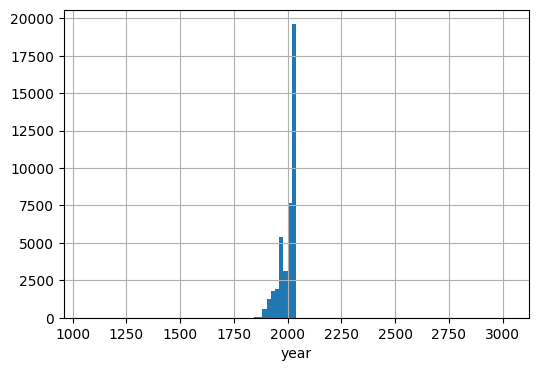

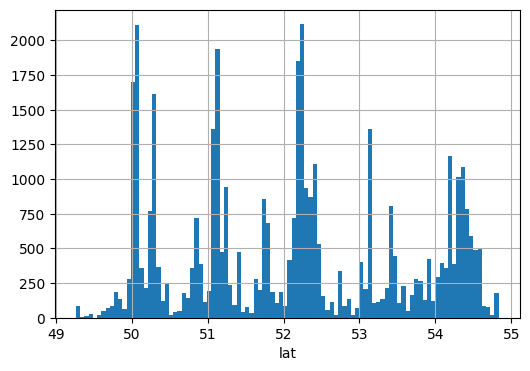

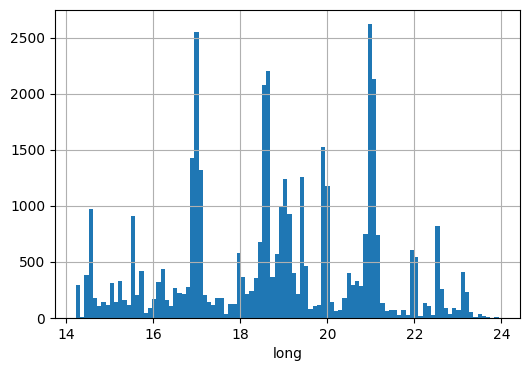

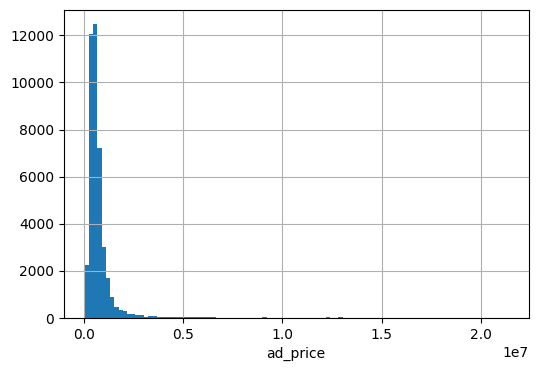

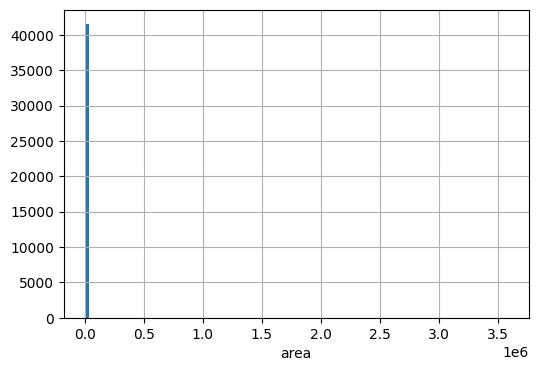

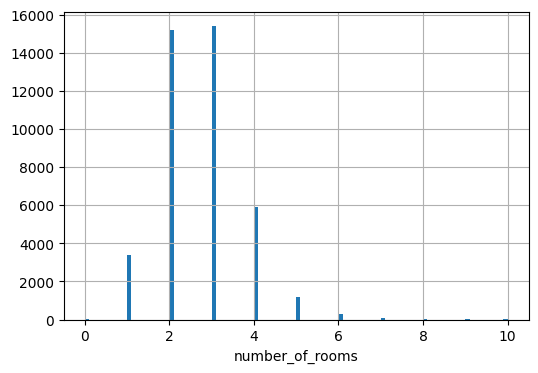

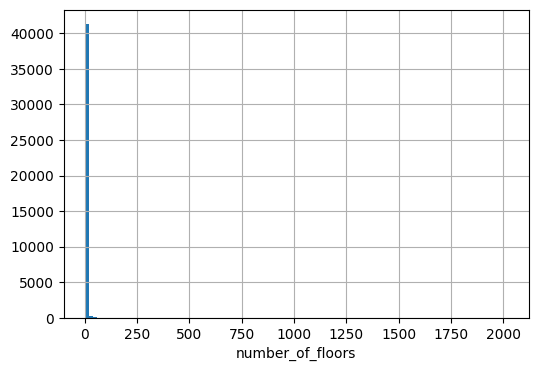

In [39]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
for column in numerical_columns:
    if all(value in [0, 1] for value in df[column].unique()):
        continue
    plt.figure(figsize=(6, 4))
    plt.hist(df[column], bins=100)
    plt.xlabel(column)
    plt.grid(True)
    plt.show()

### Correlation

In [40]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

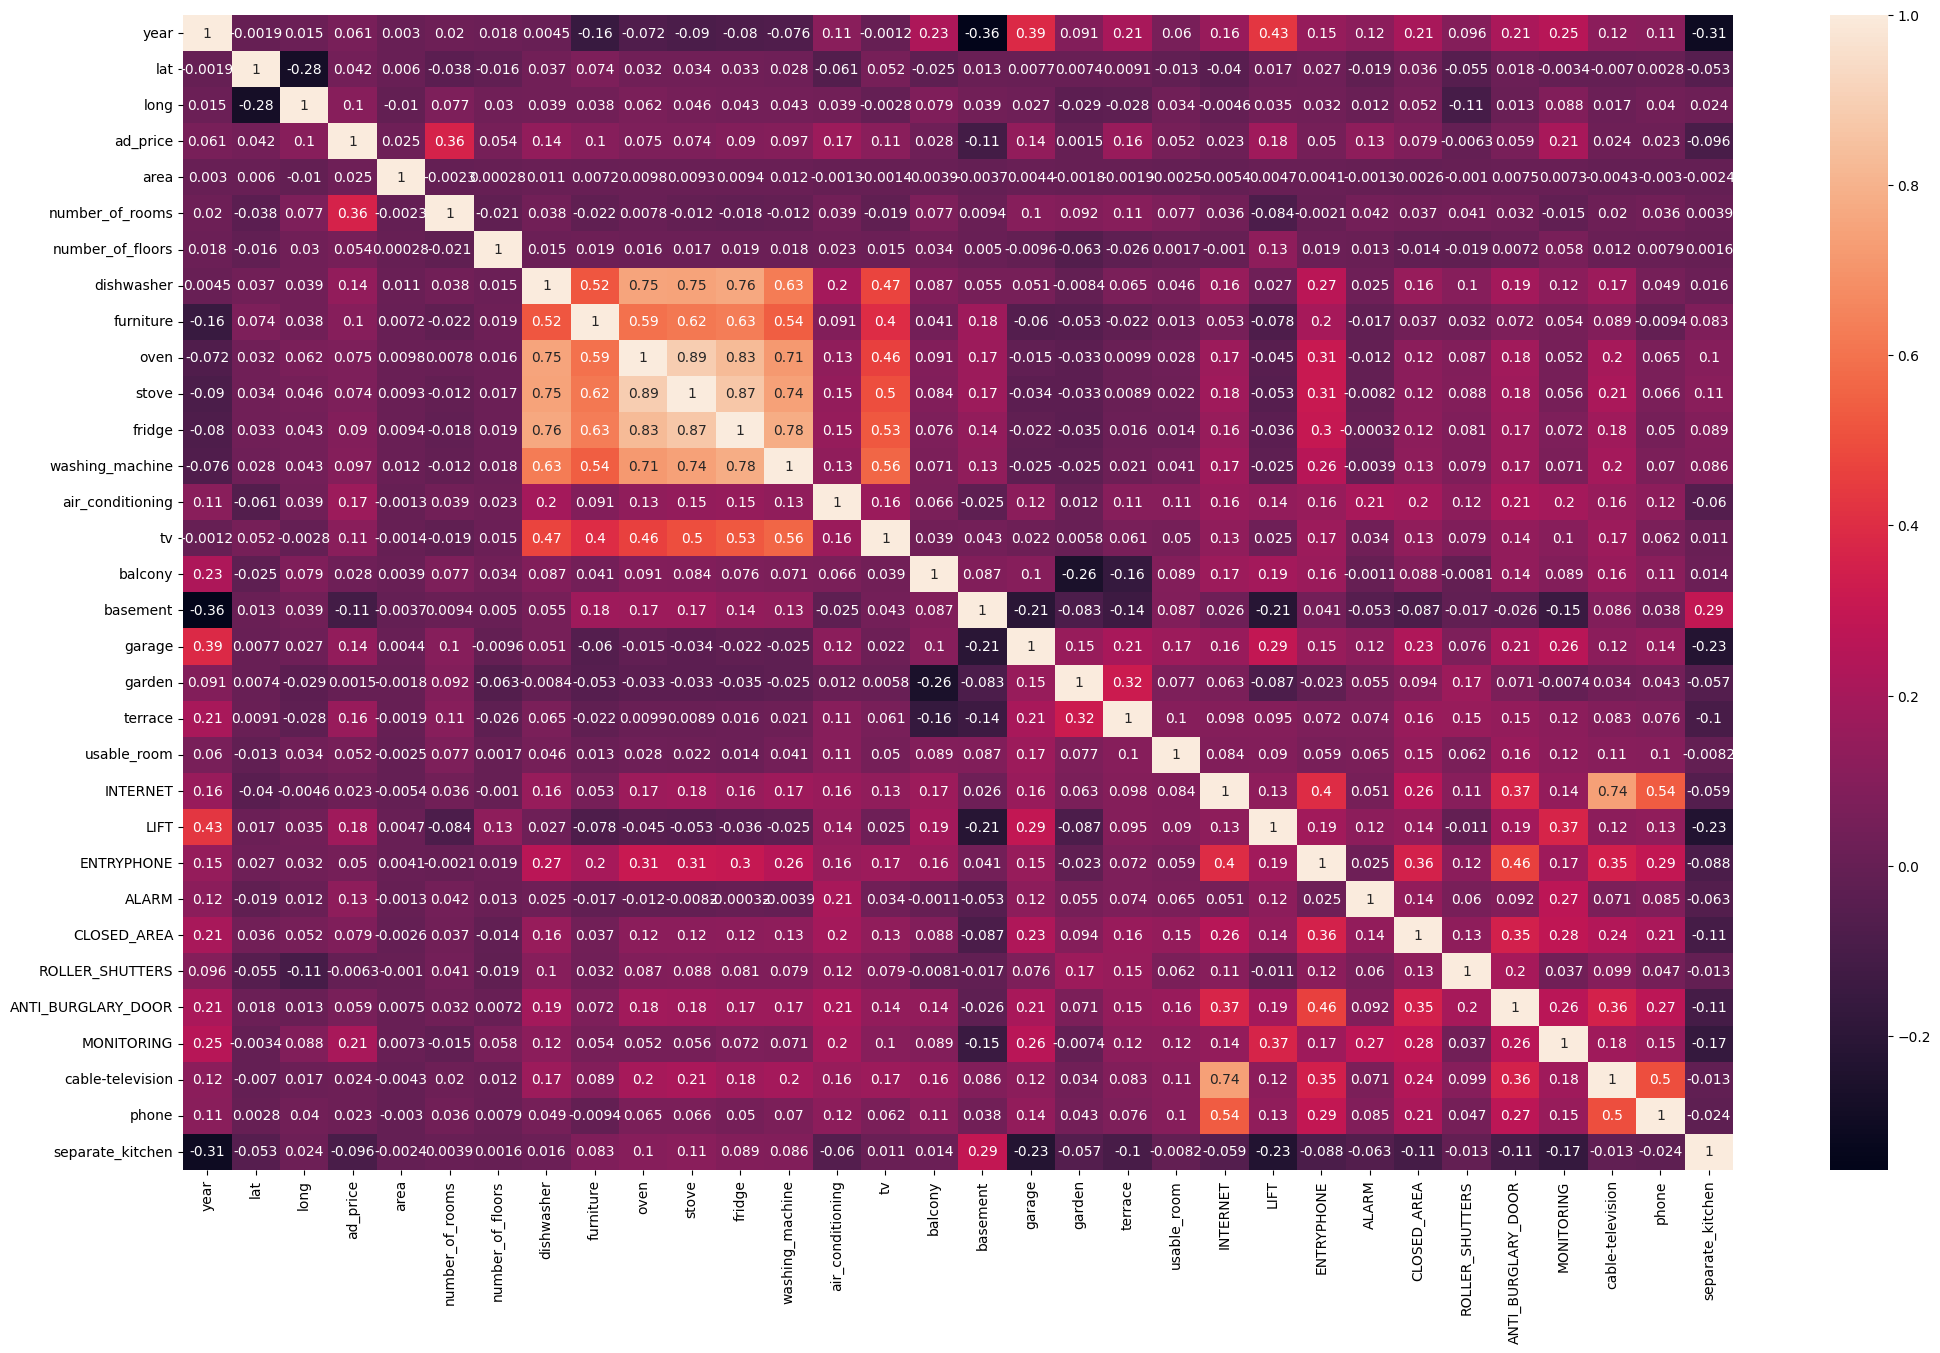

In [41]:
plt.figure(figsize=(25,15))
sns.heatmap(df[numerical_columns].corr(), annot=True);

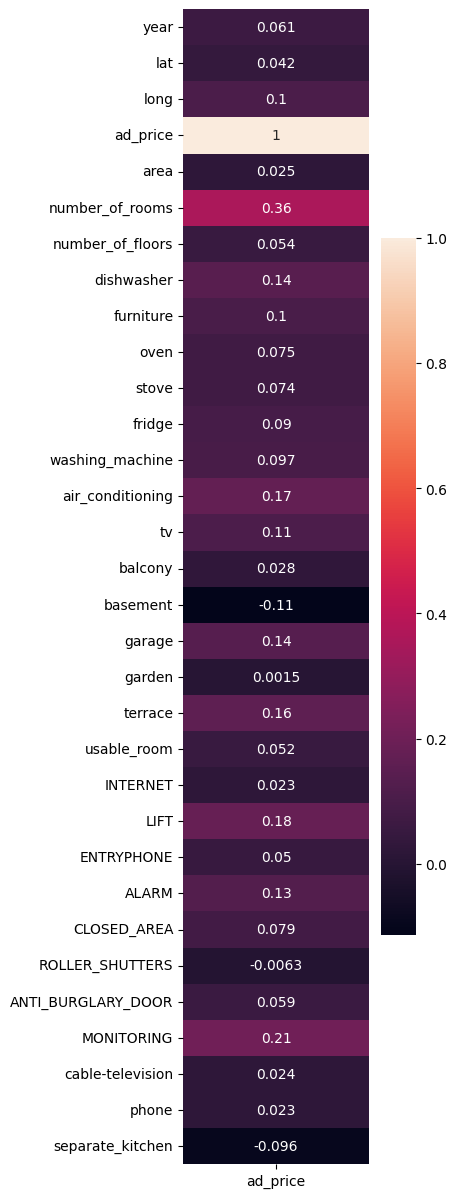

In [42]:
plt.figure(figsize=(3,15))
sns.heatmap(pd.DataFrame(df[numerical_columns].corr()['ad_price']), annot=True);

In [43]:
(x := df
 .corr(numeric_only=True)
 .abs()['ad_price']
).sort_values(ascending=False)[x > 0.5].index

Index(['ad_price'], dtype='object')

In [44]:
(x := df
 .corr(numeric_only=True)
 .abs()['ad_price']
).sort_values(ascending=False)[x > 0.15].index

Index(['ad_price', 'number_of_rooms', 'MONITORING', 'LIFT', 'air_conditioning',
       'terrace'],
      dtype='object')

# Feature Engineering

## Adjusting existing features

### floor

In [45]:
df.floor.value_counts()

floor
FLOOR_1            10379
GROUND_FLOOR        8599
FLOOR_2             7859
FLOOR_3             6377
FLOOR_4             4116
FLOOR_5             1348
FLOOR_6              829
FLOOR_7              547
FLOOR_HIGHER_10      416
FLOOR_8              377
FLOOR_9              273
FLOOR_10             252
GARRET                72
CELLAR                29
Name: count, dtype: int64

In [46]:
def process_floor(floor):
    if floor == 'CELLAR':
        return -1
    elif floor == 'GROUND_FLOOR':
        return 0
    elif floor == 'FLOOR_HIGHER_10':
        return 11
    elif floor == 'GARRET':
        return 12
    else:
        return int(floor.split('_')[-1])

In [47]:
df.floor = df.floor.apply(process_floor)

### windows

In [48]:
df.windows.value_counts(normalize=True)

windows
PLASTIC      0.939864
WOODEN       0.048296
ALUMINIUM    0.011839
Name: proportion, dtype: float64

In [49]:
df.windows = df.windows.replace(['WOODEN', 'ALUMINIUM'], 'NON_PLASTIC')

### heating

In [50]:
df.heating.value_counts(normalize=True)

heating
URBAN          0.697466
GAS            0.201119
OTHER          0.056591
BOILER_ROOM    0.022931
ELECTRICAL     0.020061
TILED_STOVE    0.001833
Name: proportion, dtype: float64

In [51]:
df.heating = df.heating.replace(['TILED_STOVE', 'ELECTRICAL', 'BOILER_ROOM'], 'OTHER')

### condition

In [52]:
df.condition.value_counts(normalize=True)

condition
READY_TO_USE     0.508114
TO_COMPLETION    0.408844
TO_RENOVATION    0.083042
Name: proportion, dtype: float64

In [53]:
df.condition = df.condition.replace('TO_RENOVATION', 'TO_COMPLETION')

### ownership

In [54]:
df.ownership.value_counts(normalize=True)

ownership
FULL_OWNERSHIP       0.953849
LIMITED_OWNERSHIP    0.041834
SHARE                0.003231
USUFRUCT             0.001085
Name: proportion, dtype: float64

In [55]:
df.ownership = df.ownership.replace(['SHARE', 'USUFRUCT'], 'LIMITED_OWNERSHIP')

### price_currency

In [56]:
df.price_currency.unique()

array(['PLN', 'EUR'], dtype=object)

In [57]:
df.loc[df['price_currency'] == 'EUR', 'ad_price'] = df['ad_price'] * 4.35
df.loc[df['price_currency'] == 'USD', 'ad_price'] = df['ad_price'] * 4
df = df.drop(columns=['price_currency'])

### city_name

In [58]:
punctuation_chars = set(string.punctuation)
whitespace_chars = set(string.whitespace)
special_chars = punctuation_chars - {'-'} | whitespace_chars

df['city_name'] = df['city_name'].apply(lambda x: '_'.join(x.split('_')[:-1]) if x.split('_')[-1].isdigit() else x)

### building_type

In [59]:
df.building_type.value_counts(normalize=True)

building_type
BLOCK        0.546283
APARTMENT    0.279965
TENEMENT     0.115545
RIBBON       0.030839
HOUSE        0.024691
INFILL       0.001350
LOFT         0.001326
Name: proportion, dtype: float64

In [60]:
df.building_type = df.building_type.replace(['INFILL', 'LOFT', 'HOUSE', 'RIBBON'], 'OTHER')

## Adding new features

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41473 entries, 0 to 41472
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   floor               41473 non-null  int64  
 1   year                41473 non-null  float64
 2   windows             41473 non-null  object 
 3   heating             41473 non-null  object 
 4   condition           41473 non-null  object 
 5   ownership           41473 non-null  object 
 6   lat                 41473 non-null  float64
 7   long                41473 non-null  float64
 8   ad_price            41473 non-null  float64
 9   city_name           41473 non-null  object 
 10  market              41473 non-null  object 
 11  region_name         41473 non-null  object 
 12  area                41473 non-null  float64
 13  number_of_rooms     41473 non-null  int64  
 14  number_of_floors    41473 non-null  float64
 15  building_type       41473 non-null  object 
 16  dish

### building_age

In [62]:
df['building_age'] = df['year'].apply(lambda x: age if (age := datetime.now().year - x) >= 0 else 0)

### population, city_area, population_density

In [63]:
df_cities_data = pd.read_csv('data/cities_data.txt', sep=',')  # https://pl.wikipedia.org/wiki/Dane_statystyczne_o_miastach_w_Polsce

In [64]:
df_cities_data.head()

city_name    subregion_id         region_name  city_area  \
0  Aleksandrów Kujawski  aleksandrowski  kujawsko-pomorskie        723   
1    Aleksandrów Łódzki        zgierski             łódzkie       1382   
2              Alwernia     chrzanowski         małopolskie        888   
3             Andrychów       wadowicki         małopolskie       1033   
4               Annopol       kraśnicki           lubelskie        773   

   population  population_density  
0       12058                1668  
1       21754                1574  
2        3336                 376  
3       19837                1920  
4        2436                 315

In [65]:
df_cities_data['city_name'] = df_cities_data['city_name'].apply(lambda x: '-'.join(unidecode(x).lower().split()))

In [66]:
df_cities_data.head()

city_name    subregion_id         region_name  city_area  \
0  aleksandrow-kujawski  aleksandrowski  kujawsko-pomorskie        723   
1    aleksandrow-lodzki        zgierski             łódzkie       1382   
2              alwernia     chrzanowski         małopolskie        888   
3             andrychow       wadowicki         małopolskie       1033   
4               annopol       kraśnicki           lubelskie        773   

   population  population_density  
0       12058                1668  
1       21754                1574  
2        3336                 376  
3       19837                1920  
4        2436                 315

In [67]:
df[df.city_name.apply(lambda x: x not in df_cities_data.city_name.tolist())].__len__()

3041

In [68]:
cities_names = df_cities_data.city_name.to_list()
def create_feature(city_name, feature_name):
    if not city_name in cities_names:
        return None
    else:
        return df_cities_data[df_cities_data.city_name == city_name][feature_name].iloc[0]

In [69]:
df['population'] = df.city_name.apply(create_feature, args=('population',))

In [70]:
df['city_area'] = df.city_name.apply(create_feature, args=('city_area',))

In [71]:
df['population_density'] = df.city_name.apply(create_feature, args=('population_density',))

In [72]:
df.drop(columns=['city_name'], inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Data Preprocessing

In [73]:
df.describe()

floor          year           lat          long      ad_price  \
count  38432.000000  38432.000000  38432.000000  38432.000000  3.843200e+04   
mean       2.272117   1998.098954     52.052245     18.880904  6.920419e+05   
std        2.172879     36.401955      1.459129      2.146004  6.153631e+05   
min       -1.000000   1056.000000     49.282100     14.225321  2.965200e+04   
25%        1.000000   1980.000000     50.879646     17.041646  3.990000e+05   
50%        2.000000   2017.000000     52.164561     18.938684  5.600000e+05   
75%        3.000000   2023.000000     53.151354     20.879596  7.850000e+05   
max       12.000000   3022.000000     54.808480     23.896709  2.135010e+07   

               area  number_of_rooms  number_of_floors    dishwasher  \
count  3.843200e+04     38432.000000      38432.000000  38432.000000   
mean   1.544165e+02         2.703190          4.507494      0.162781   
std    1.826344e+04         0.990776         10.762920      0.369171   
min    1.000000e+00         0.000000          1.000000      0.000000   
25%    4.389000e+01         2.000000          3.000000      0.000000   
50%    5.570000e+01         3.000000          4.000000      0.000000   
75%    7.001000e+01         3.000000          5.000000      0.000000   
max    3.580432e+06        10.000000       2019.000000      1.000000   

          furniture          oven         stove        fridge  \
count  38432.000000  38432.000000  38432.000000  38432.000000   
mean       0.323585      0.207353      0.222419      0.216799   
std        0.467850      0.405416      0.415876      0.412070   
min        0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000   
75%        1.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000   

       washing_machine  air_conditioning            tv       balcony  \
count     38432.000000      38432.000000  38432.000000  38432.000000   
mean          0.157291          0.077097      0.075614      0.624532   
std           0.364079          0.266749      0.264383      0.484250   
min           0.000000          0.000000      0.000000      0.000000   
25%           0.000000          0.000000      0.000000      0.000000   
50%           0.000000          0.000000      0.000000      1.000000   
75%           0.000000          0.000000      0.000000      1.000000   
max           1.000000          1.000000      1.000000      1.000000   

           basement        garage        garden       terrace   usable_room  \
count  38432.000000  38432.000000  38432.000000  38432.000000  38432.000000   
mean       0.376951      0.555839      0.125624      0.148184      0.223590   
std        0.484629      0.496879      0.331430      0.355287      0.416656   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      1.000000      0.000000      0.000000      0.000000   
75%        1.000000      1.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

           INTERNET         LIFT    ENTRYPHONE         ALARM   CLOSED_AREA  \
count  38432.000000  38432.00000  38432.000000  38432.000000  38432.000000   
mean       0.545379      0.51569      0.594791      0.079543      0.228820   
std        0.497943      0.49976      0.490939      0.270588      0.420078   
min        0.000000      0.00000      0.000000      0.000000      0.000000   
25%        0.000000      0.00000      0.000000      0.000000      0.000000   
50%        1.000000      1.00000      1.000000      0.000000      0.000000   
75%        1.000000      1.00000      1.000000      0.000000      0.000000   
max        1.000000      1.00000      1.000000      1.000000      1.000000   

   

## Scaling

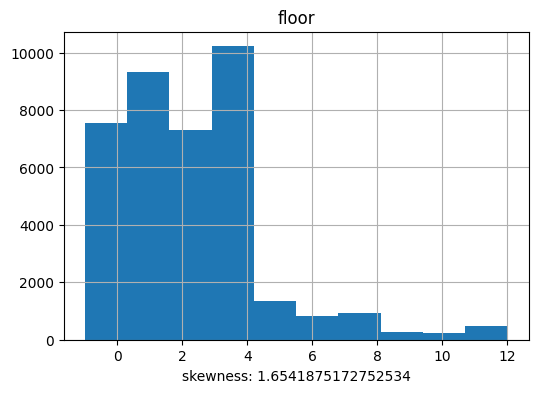

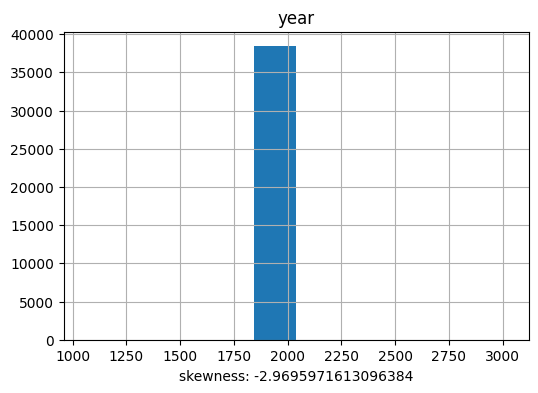

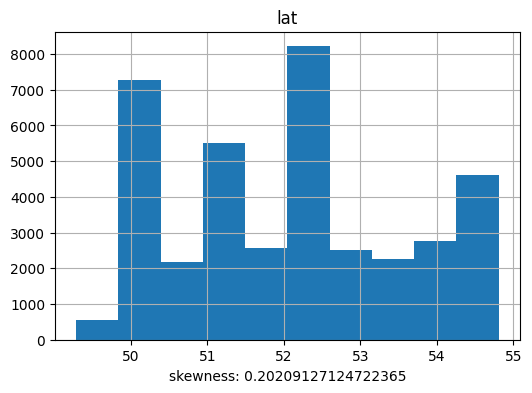

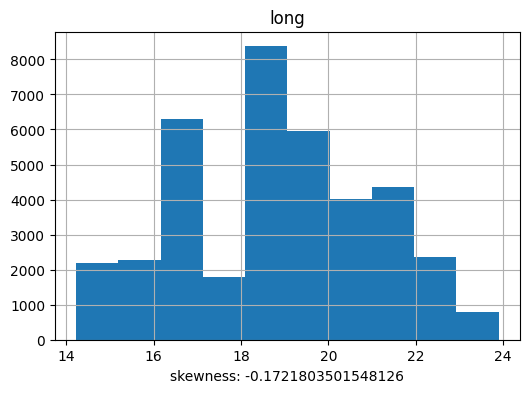

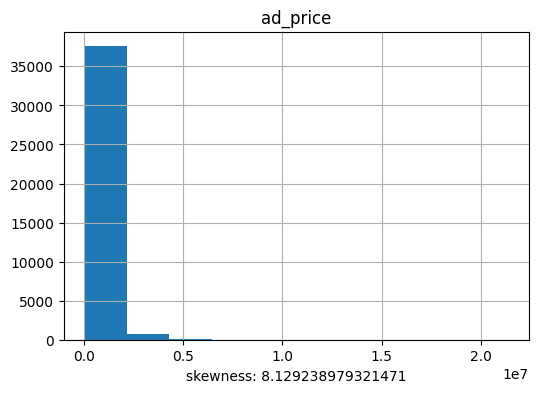

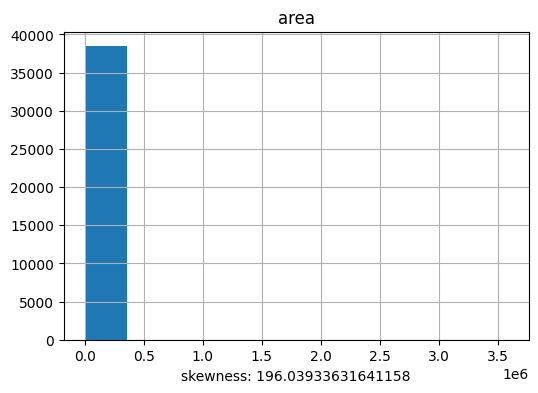

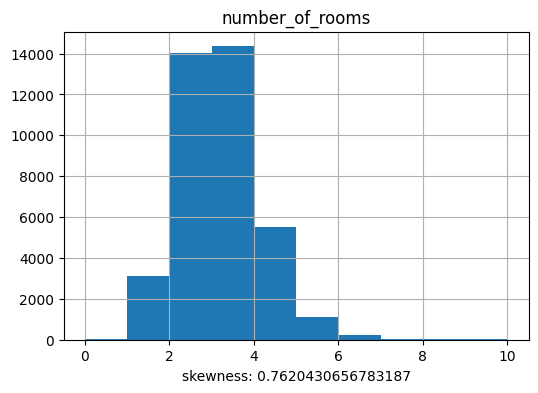

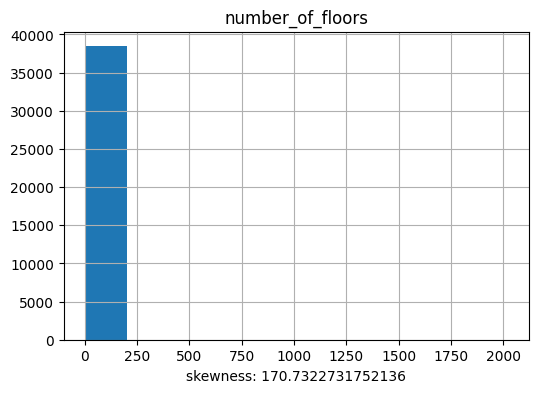

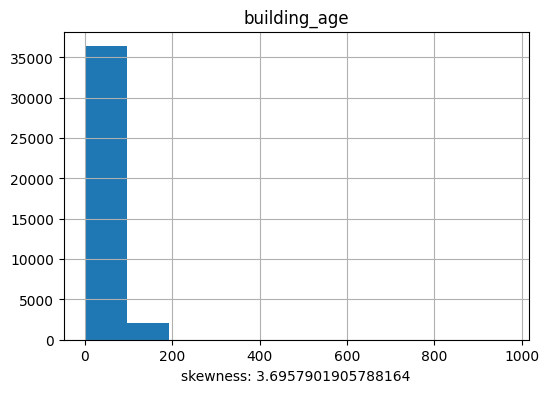

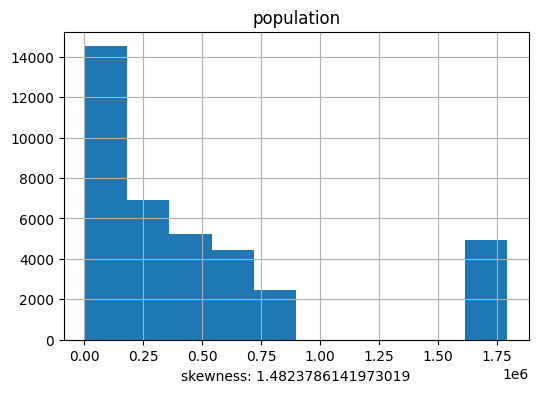

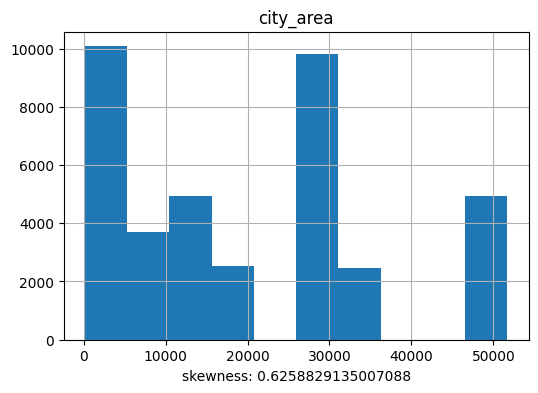

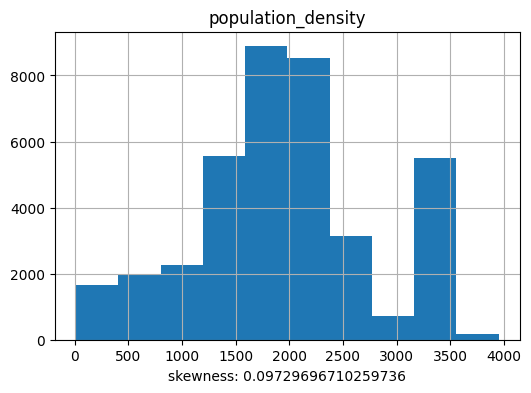

In [74]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
for column in numerical_columns:
    if all(value in [0, 1] for value in df[column].unique()):
        continue
    plt.figure(figsize=(6, 4))
    plt.hist(df[column])
    plt.title(column)
    plt.xlabel(f'skewness: {df[column].skew()}')
    plt.grid(True)
    plt.show()

In [75]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).drop(columns=['ad_price']).columns.tolist()
non_01_columns = [column for column in numerical_columns if not all(value in [0, 1] for value in df[column].unique())]
skewed = [column for column in non_01_columns if np.abs(df[column].skew()) > 0.5]
near_normal = [column for column in non_01_columns if column not in skewed]

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38432 entries, 0 to 38431
Data columns (total 44 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   floor               38432 non-null  int64  
 1   year                38432 non-null  float64
 2   windows             38432 non-null  object 
 3   heating             38432 non-null  object 
 4   condition           38432 non-null  object 
 5   ownership           38432 non-null  object 
 6   lat                 38432 non-null  float64
 7   long                38432 non-null  float64
 8   ad_price            38432 non-null  float64
 9   market              38432 non-null  object 
 10  region_name         38432 non-null  object 
 11  area                38432 non-null  float64
 12  number_of_rooms     38432 non-null  int64  
 13  number_of_floors    38432 non-null  float64
 14  building_type       38432 non-null  object 
 15  dishwasher          38432 non-null  int64  
 16  furn

In [77]:
transformer = PowerTransformer()
skewed_transformed = transformer.fit_transform(df[skewed])
df_transformed = pd.DataFrame(skewed_transformed, columns=skewed)

In [78]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[near_normal])
df_scaled = pd.DataFrame(scaled, columns=near_normal)

/tmp/ipykernel_1031612/3977072582.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


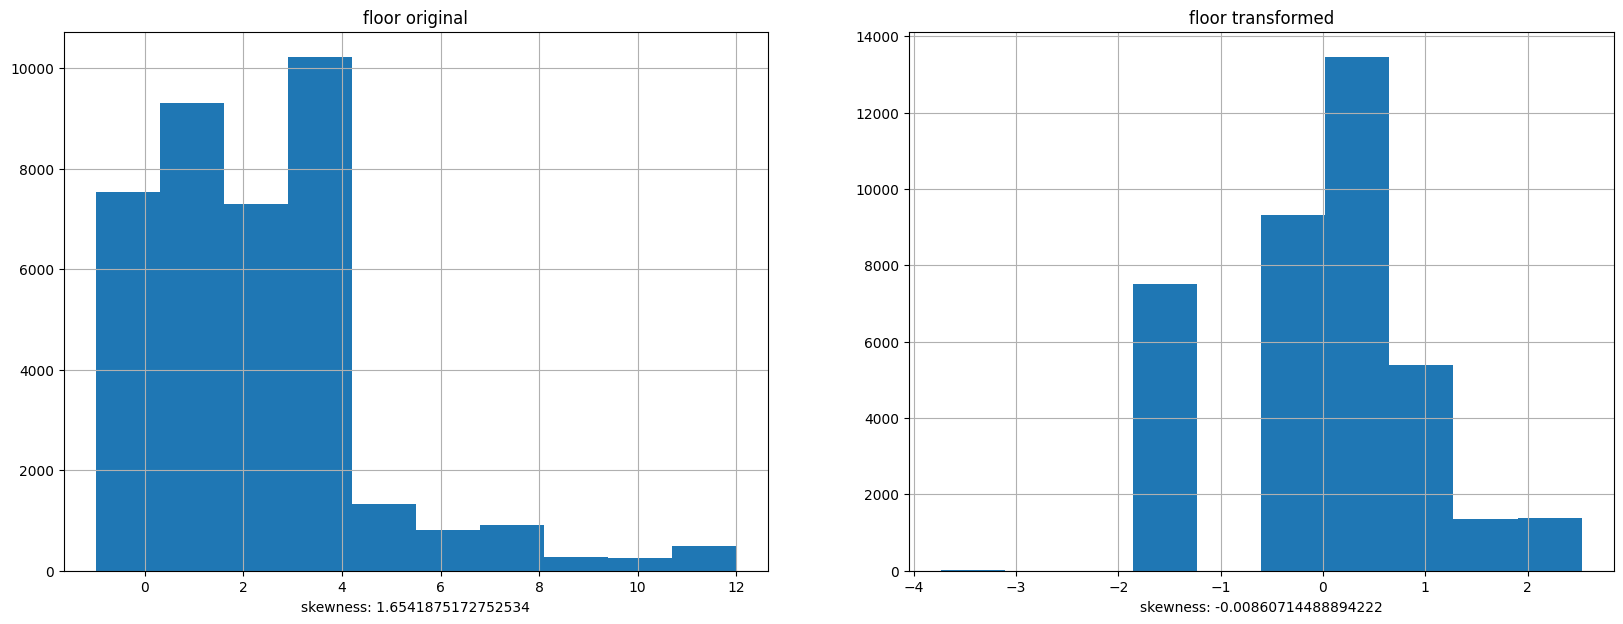

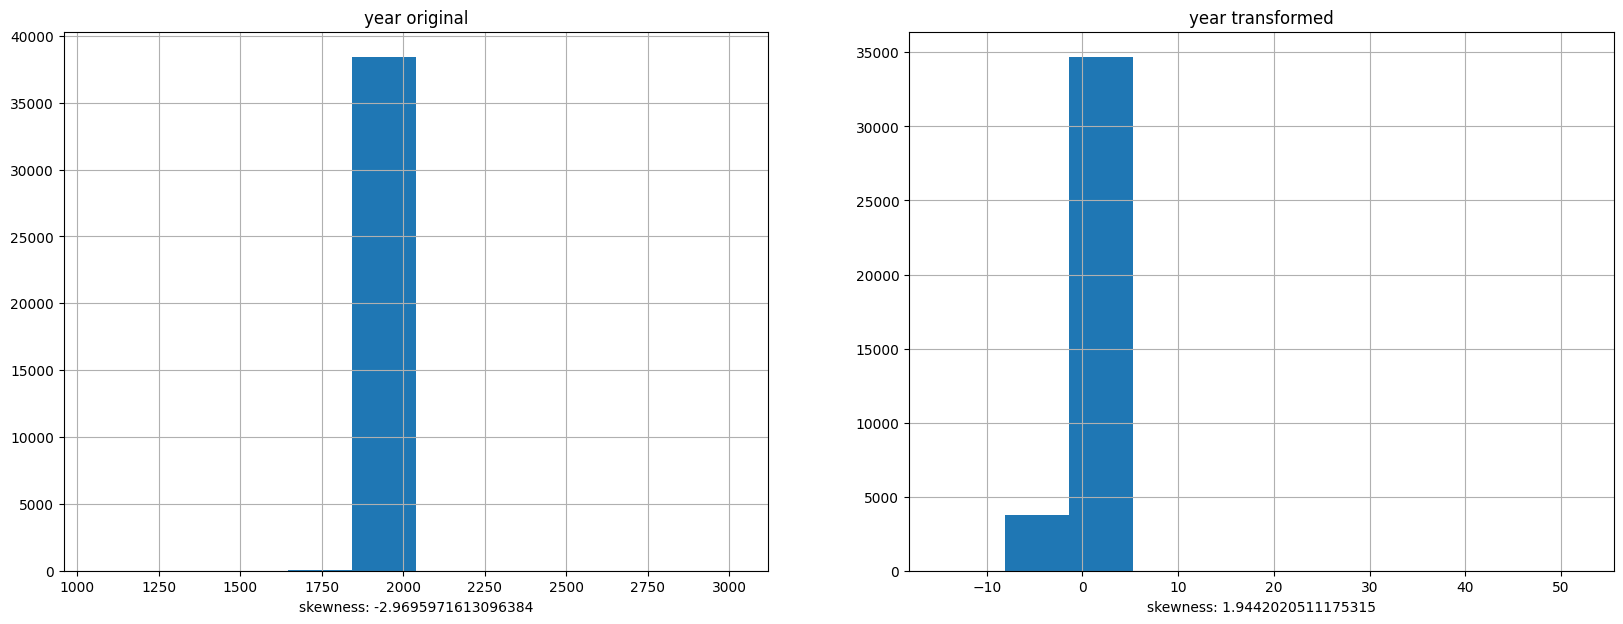

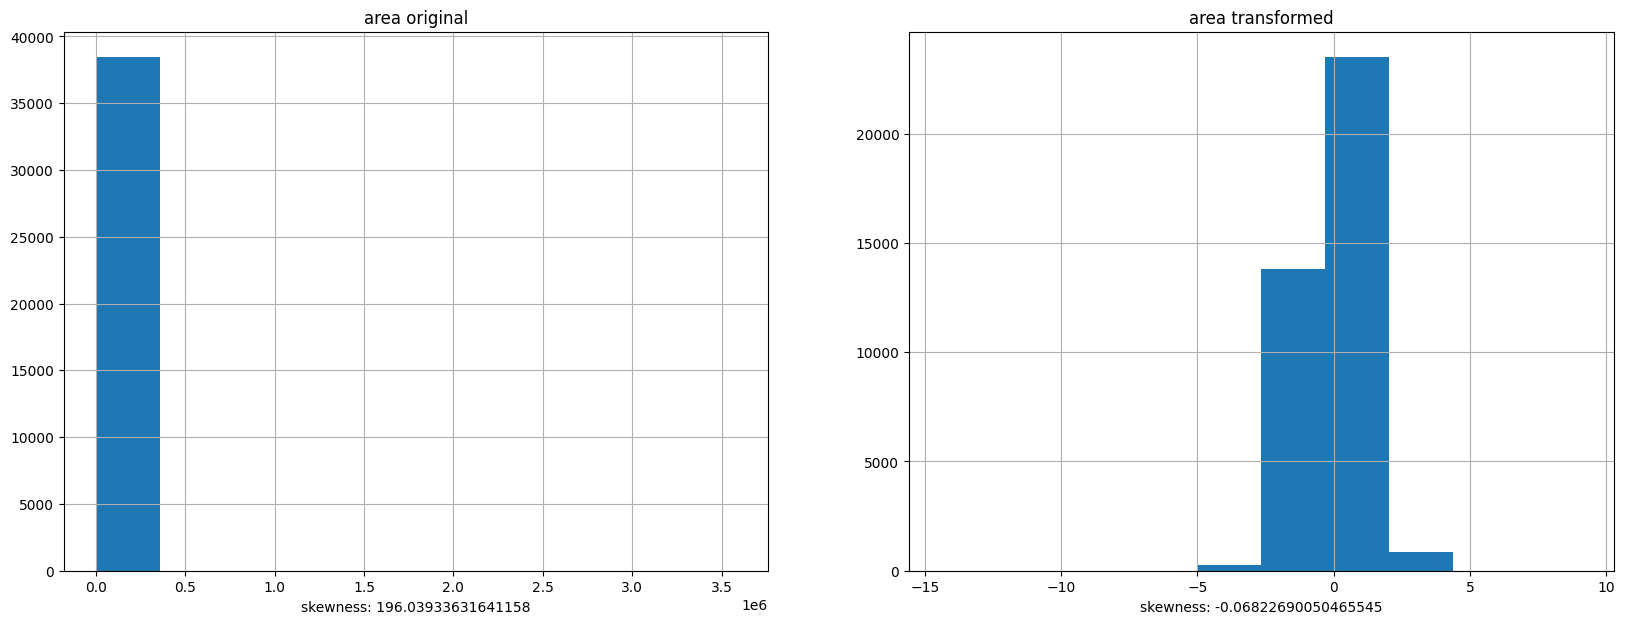

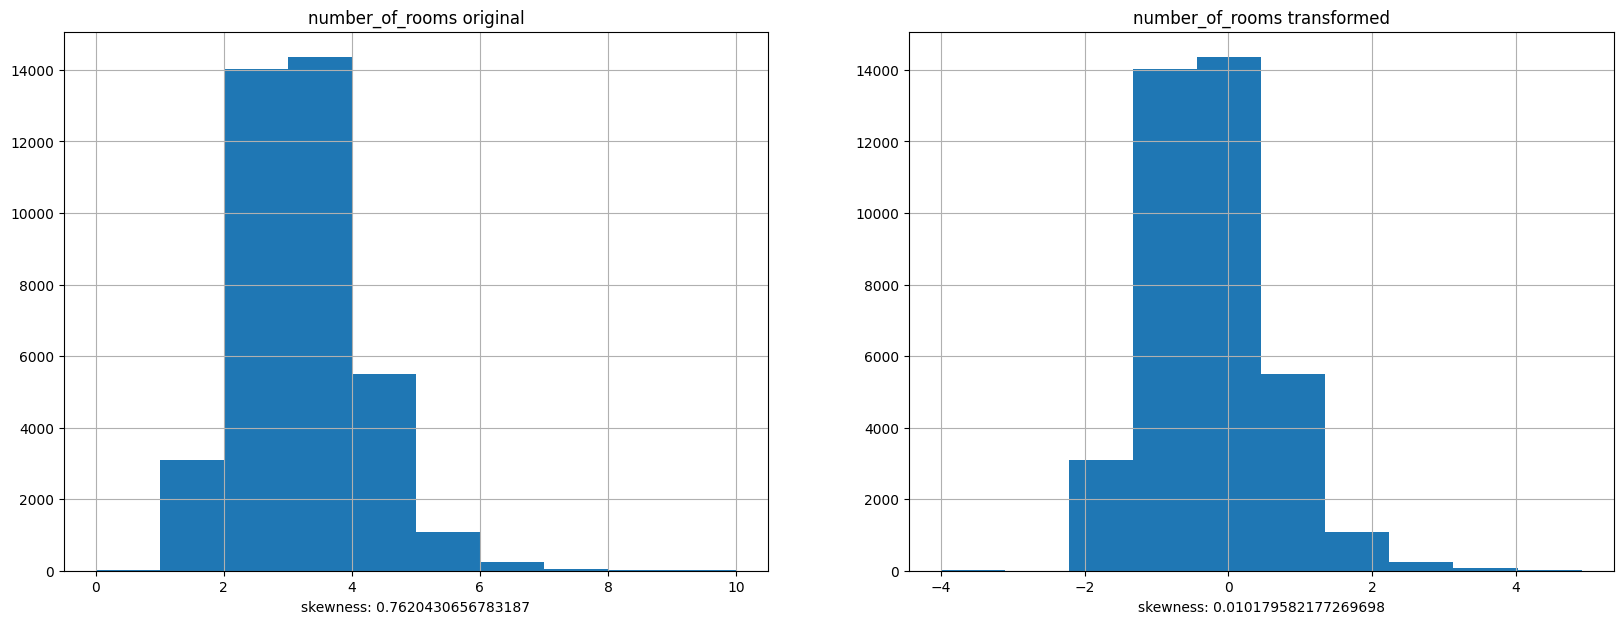

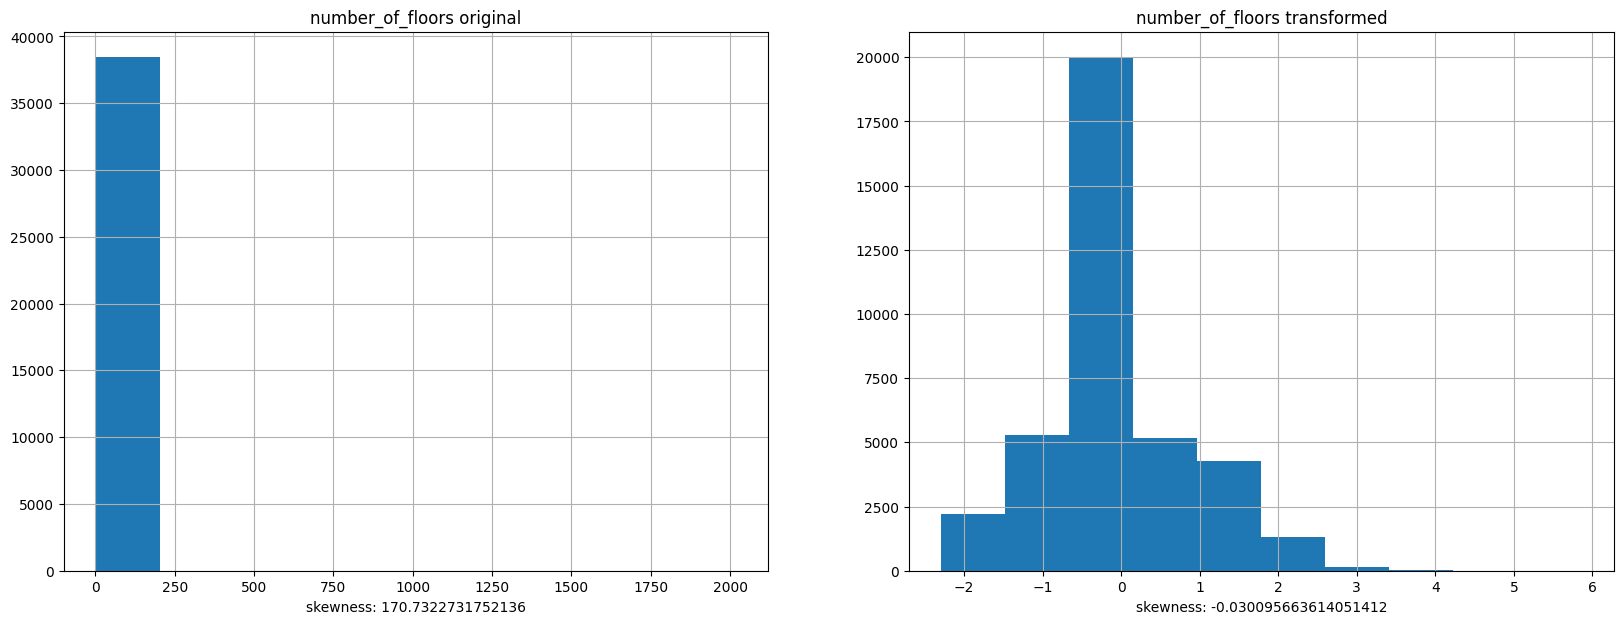

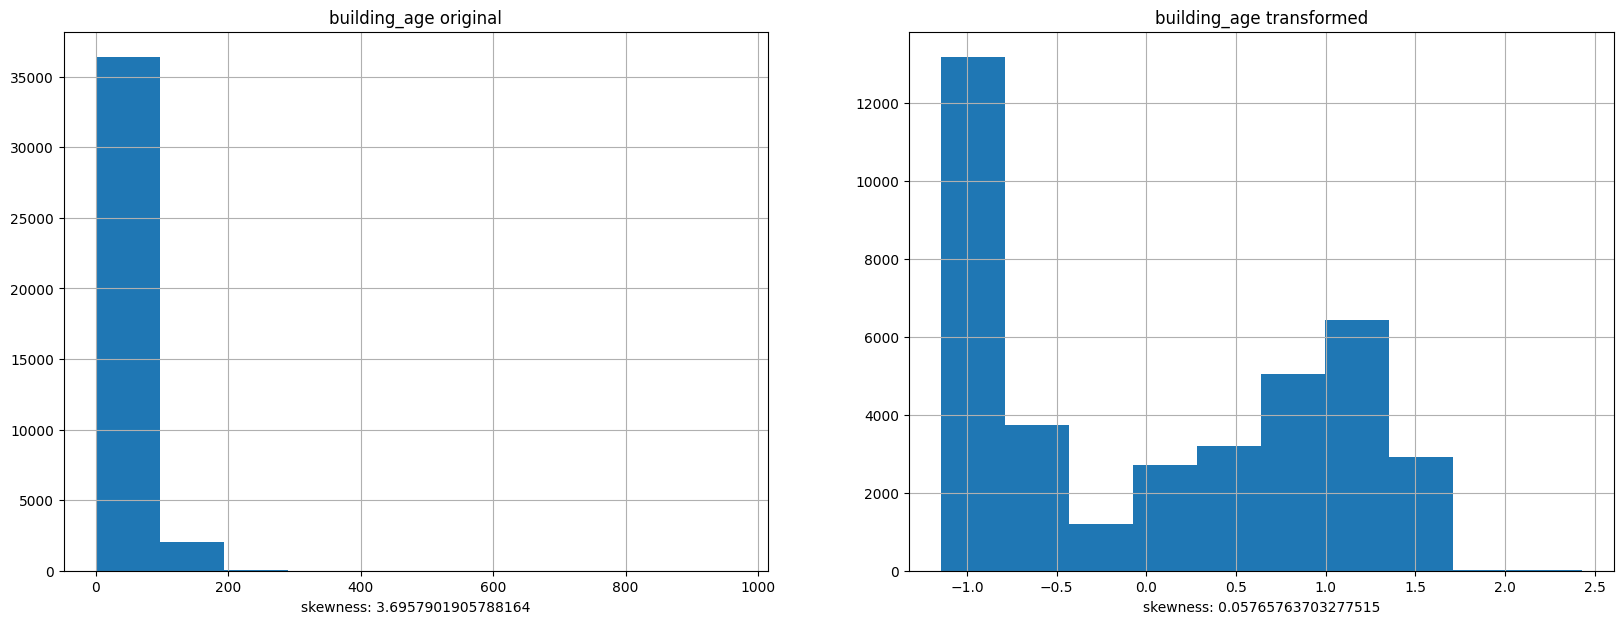

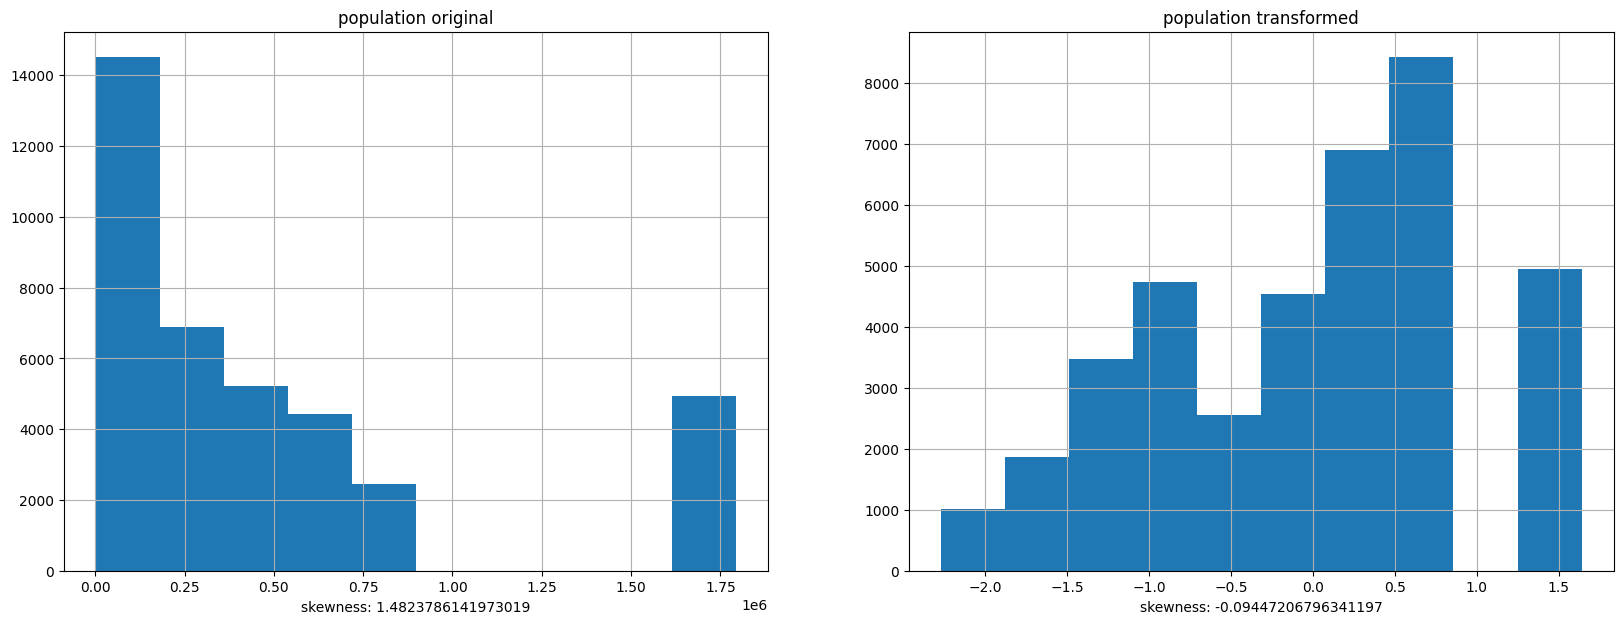

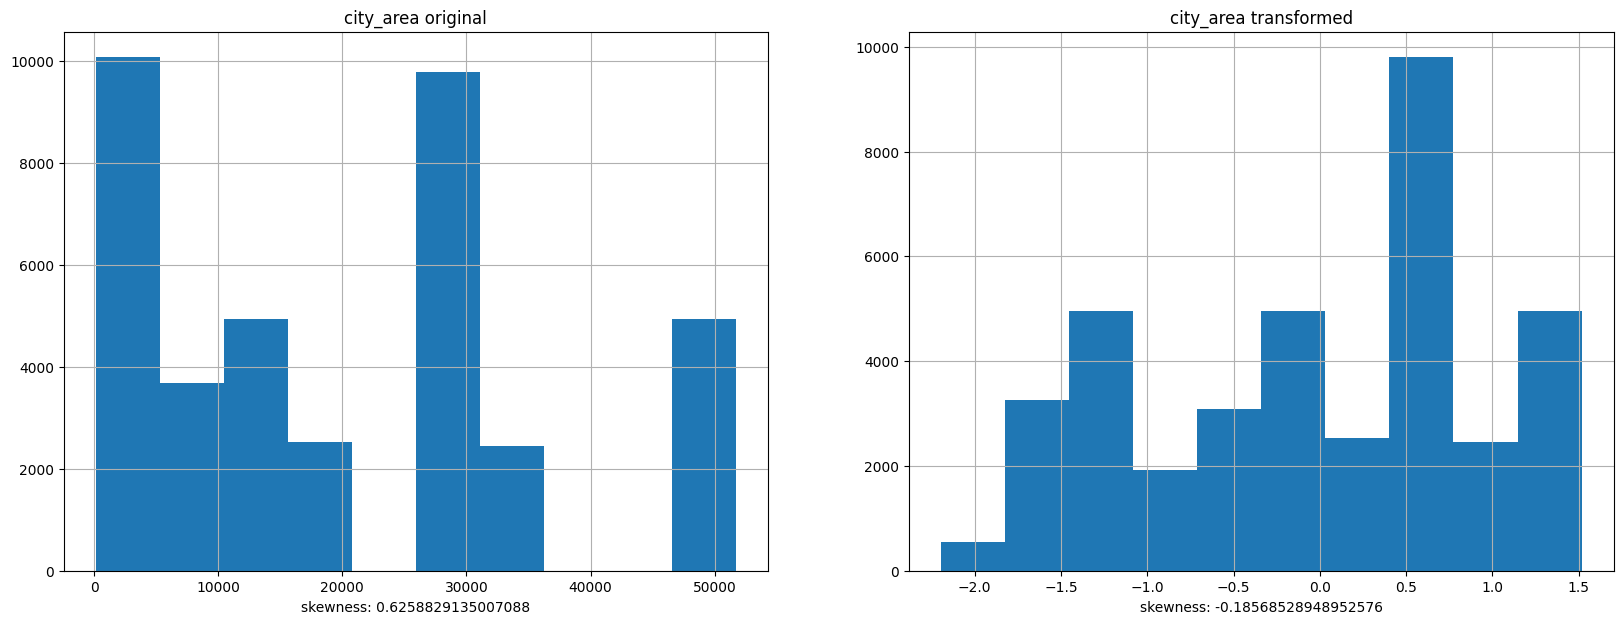

In [79]:
for column in skewed:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
    ax[0].hist(df[column])
    ax[0].set_title(f'{column} original')
    ax[0].set_xlabel(f'skewness: {df[column].skew()}')
    ax[0].grid(True)
    ax[1].hist(df_transformed[column])
    ax[1].set_title(f'{column} transformed')
    ax[1].set_xlabel(f'skewness: {df_transformed[column].skew()}')
    ax[1].grid(True)
    fig.show()

In [80]:
df[skewed] = pd.DataFrame(skewed_transformed, columns=skewed)
df[near_normal] = pd.DataFrame(scaled, columns=near_normal)

In [81]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).drop(columns=['ad_price']).columns.tolist()
non_01_columns = [column for column in numerical_columns if not all(value in [0, 1] for value in df[column].unique())]
skewed = [column for column in non_01_columns if np.abs(df[column].skew()) > 0.5]

In [82]:
skewed

['year']

In [83]:
df.drop(columns=skewed, inplace=True)
df.reset_index(drop=True, inplace=True)

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38432 entries, 0 to 38431
Data columns (total 43 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   floor               38432 non-null  float64
 1   windows             38432 non-null  object 
 2   heating             38432 non-null  object 
 3   condition           38432 non-null  object 
 4   ownership           38432 non-null  object 
 5   lat                 38432 non-null  float64
 6   long                38432 non-null  float64
 7   ad_price            38432 non-null  float64
 8   market              38432 non-null  object 
 9   region_name         38432 non-null  object 
 10  area                38432 non-null  float64
 11  number_of_rooms     38432 non-null  float64
 12  number_of_floors    38432 non-null  float64
 13  building_type       38432 non-null  object 
 14  dishwasher          38432 non-null  int64  
 15  furniture           38432 non-null  int64  
 16  oven

In [85]:
df.describe()

floor           lat          long      ad_price          area  \
count  3.843200e+04  38432.000000  38432.000000  3.843200e+04  3.843200e+04   
mean  -2.218597e-17      0.501259      0.481377  6.920419e+05  9.051877e-16   
std    1.000013e+00      0.264030      0.221892  6.153631e+05  1.000013e+00   
min   -3.731062e+00      0.000000      0.000000  2.965200e+04 -1.440944e+01   
25%   -4.649376e-01      0.289076      0.291202  3.990000e+05 -6.093174e-01   
50%    1.646983e-01      0.521582      0.487351  5.600000e+05  2.435471e-02   
75%    6.175052e-01      0.700143      0.688037  7.850000e+05  5.975005e-01   
max    2.526625e+00      1.000000      1.000000  2.135010e+07  9.095303e+00   

       number_of_rooms  number_of_floors    dishwasher     furniture  \
count     3.843200e+04      3.843200e+04  38432.000000  38432.000000   
mean      2.603154e-16      1.109299e-15      0.162781      0.323585   
std       1.000013e+00      1.000013e+00      0.369171      0.467850   
min      -3.999012e+00     -2.291396e+00      0.000000      0.000000   
25%      -6.741565e-01     -3.880624e-01      0.000000      0.000000   
50%       3.874252e-01      1.344072e-01      0.000000      0.000000   
75%       3.874252e-01      5.325679e-01      0.000000      1.000000   
max       4.914603e+00      5.861336e+00      1.000000      1.000000   

               oven         stove        fridge  washing_machine  \
count  38432.000000  38432.000000  38432.000000     38432.000000   
mean       0.207353      0.222419      0.216799         0.157291   
std        0.405416      0.415876      0.412070         0.364079   
min        0.000000      0.000000      0.000000         0.000000   
25%        0.000000      0.000000      0.000000         0.000000   
50%        0.000000      0.000000      0.000000         0.000000   
75%        0.000000      0.000000      0.000000         0.000000   
max        1.000000      1.000000      1.000000         1.000000   

       air_conditioning            tv       balcony      basement  \
count      38432.000000  38432.000000  38432.000000  38432.000000   
mean           0.077097      0.075614      0.624532      0.376951   
std            0.266749      0.264383      0.484250      0.484629   
min            0.000000      0.000000      0.000000      0.000000   
25%            0.000000      0.000000      0.000000      0.000000   
50%            0.000000      0.000000      1.000000      0.000000   
75%            0.000000      0.000000      1.000000      1.000000   
max            1.000000      1.000000      1.000000      1.000000   

             garage        garden       terrace   usable_room      INTERNET  \
count  38432.000000  38432.000000  38432.000000  38432.000000  38432.000000   
mean       0.555839      0.125624      0.148184      0.223590      0.545379   
std        0.496879      0.331430      0.355287      0.416656      0.497943   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        1.000000      0.000000      0.000000      0.000000      1.000000   
75%        1.000000      0.000000      0.000000      0.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

              LIFT    ENTRYPHONE         ALARM   CLOSED_AREA  ROLLER_SHUTTERS  \
count  38432.00000  38432.000000  38432.000000  38432.000000     38432.000000   
mean       0.51569      0.594791      0.079543      0.228820         0.044182   
std        0.49976      0.490939      0.270588      0.420078         0.205502   
min        0.00000      0.000000      0.000000      0.000000         0.000000   
25%        0.00000      0.000000      0.000000      0.000000         0.000000   
50%        1.00000      1.000000      0.000000      0.000000         0.000000   
75%        1.00000      1.000000      0.000000      0.000000         0.000000   
max        1.00000      1.000000      1.000000      1.0000

## Outliers

In [86]:
from scipy.stats import zscore

def get_outliers_zscore(df, threshold=3):
    result = {}
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    for column in numerical_columns:
        if all(value in [0, 1] for value in df[column].unique()):
            continue
        outliers = df[abs(zscore(df[column])) > threshold]
        num_outliers = len(outliers)
        if num_outliers:
            result.update({column: {'num': num_outliers, 'values': outliers}})
    return result

def get_outliers_iqr(df):
    result = {}
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    for column in numerical_columns:
        if all(value in [0, 1] for value in df[column].unique()):
            continue
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
        num_outliers = len(outliers)
        if num_outliers:
            result.update({column: {'num': num_outliers, 'values': outliers}})
    return result

def remove_outliers_iqr(df):
    outliers_columns = get_outliers_iqr(df).keys()
    df_filtered = df.copy()
    for column in outliers_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_filtered = df_filtered[(df_filtered[column] >= lower_bound) & (df_filtered[column] <= upper_bound)]
    return df_filtered

def remove_outliers_zscore(df):
    outliers_columns = get_outliers_zscore(df).keys()
    return df[(np.abs(zscore(df[outliers_columns])) < 3).all(axis=1)]

In [87]:
outliers_zscore = get_outliers_zscore(df)
outliers_iqr = get_outliers_iqr(df)

In [88]:
for k, v in outliers_zscore.items():
    print(k, v['num'])

floor 29
ad_price 607
area 293
number_of_rooms 124
number_of_floors 142


In [89]:
for k, v in outliers_iqr.items():
    print(k, v['num'])

floor 766
ad_price 2466
area 754
number_of_rooms 1459
number_of_floors 3166
population_density 117


In [90]:
df_zscore = remove_outliers_zscore(df)
df_zscore.__len__()

37425

In [91]:
df_iqr = remove_outliers_iqr(df)
df_iqr.__len__()

31486

- removing outliers

In [92]:
# df = df_zscore
df = df_iqr

In [93]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

## One hot encoding

In [94]:
df_categorical = df.select_dtypes(include="object")
df_categorical.nunique()

windows           2
heating           3
condition         2
ownership         2
market            2
region_name      16
building_type     4
dtype: int64

In [95]:
features = ['heating', 'condition', 'ownership', 'building_type']
categories = ['OTHER', 'TO_COMPLETION', 'LIMITED_OWNERSHIP', 'OTHER']

In [96]:
ohe = OneHotEncoder(drop=categories, sparse_output=False, dtype=int)
df = pd.concat([
    df.drop(columns=features).reset_index(drop=True), 
    pd.DataFrame(ohe.fit_transform(df_categorical[features]), columns=ohe.get_feature_names_out())
], axis=1)

In [97]:
df_categorical = df.select_dtypes(include="object")
df_categorical.nunique()

windows         2
market          2
region_name    16
dtype: int64

In [98]:
ohe = OneHotEncoder(drop='first', sparse_output=False, dtype=int)
df = pd.concat([
    df.drop(columns=df_categorical.columns).reset_index(drop=True), 
    pd.DataFrame(ohe.fit_transform(df_categorical), columns=ohe.get_feature_names_out())
], axis=1)

In [99]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

## Feature selection

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31486 entries, 0 to 31485
Data columns (total 60 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   floor                            31486 non-null  float64
 1   lat                              31486 non-null  float64
 2   long                             31486 non-null  float64
 3   ad_price                         31486 non-null  float64
 4   area                             31486 non-null  float64
 5   number_of_rooms                  31486 non-null  float64
 6   number_of_floors                 31486 non-null  float64
 7   dishwasher                       31486 non-null  int64  
 8   furniture                        31486 non-null  int64  
 9   oven                             31486 non-null  int64  
 10  stove                            31486 non-null  int64  
 11  fridge                           31486 non-null  int64  
 12  washing_machine   

### Correalation

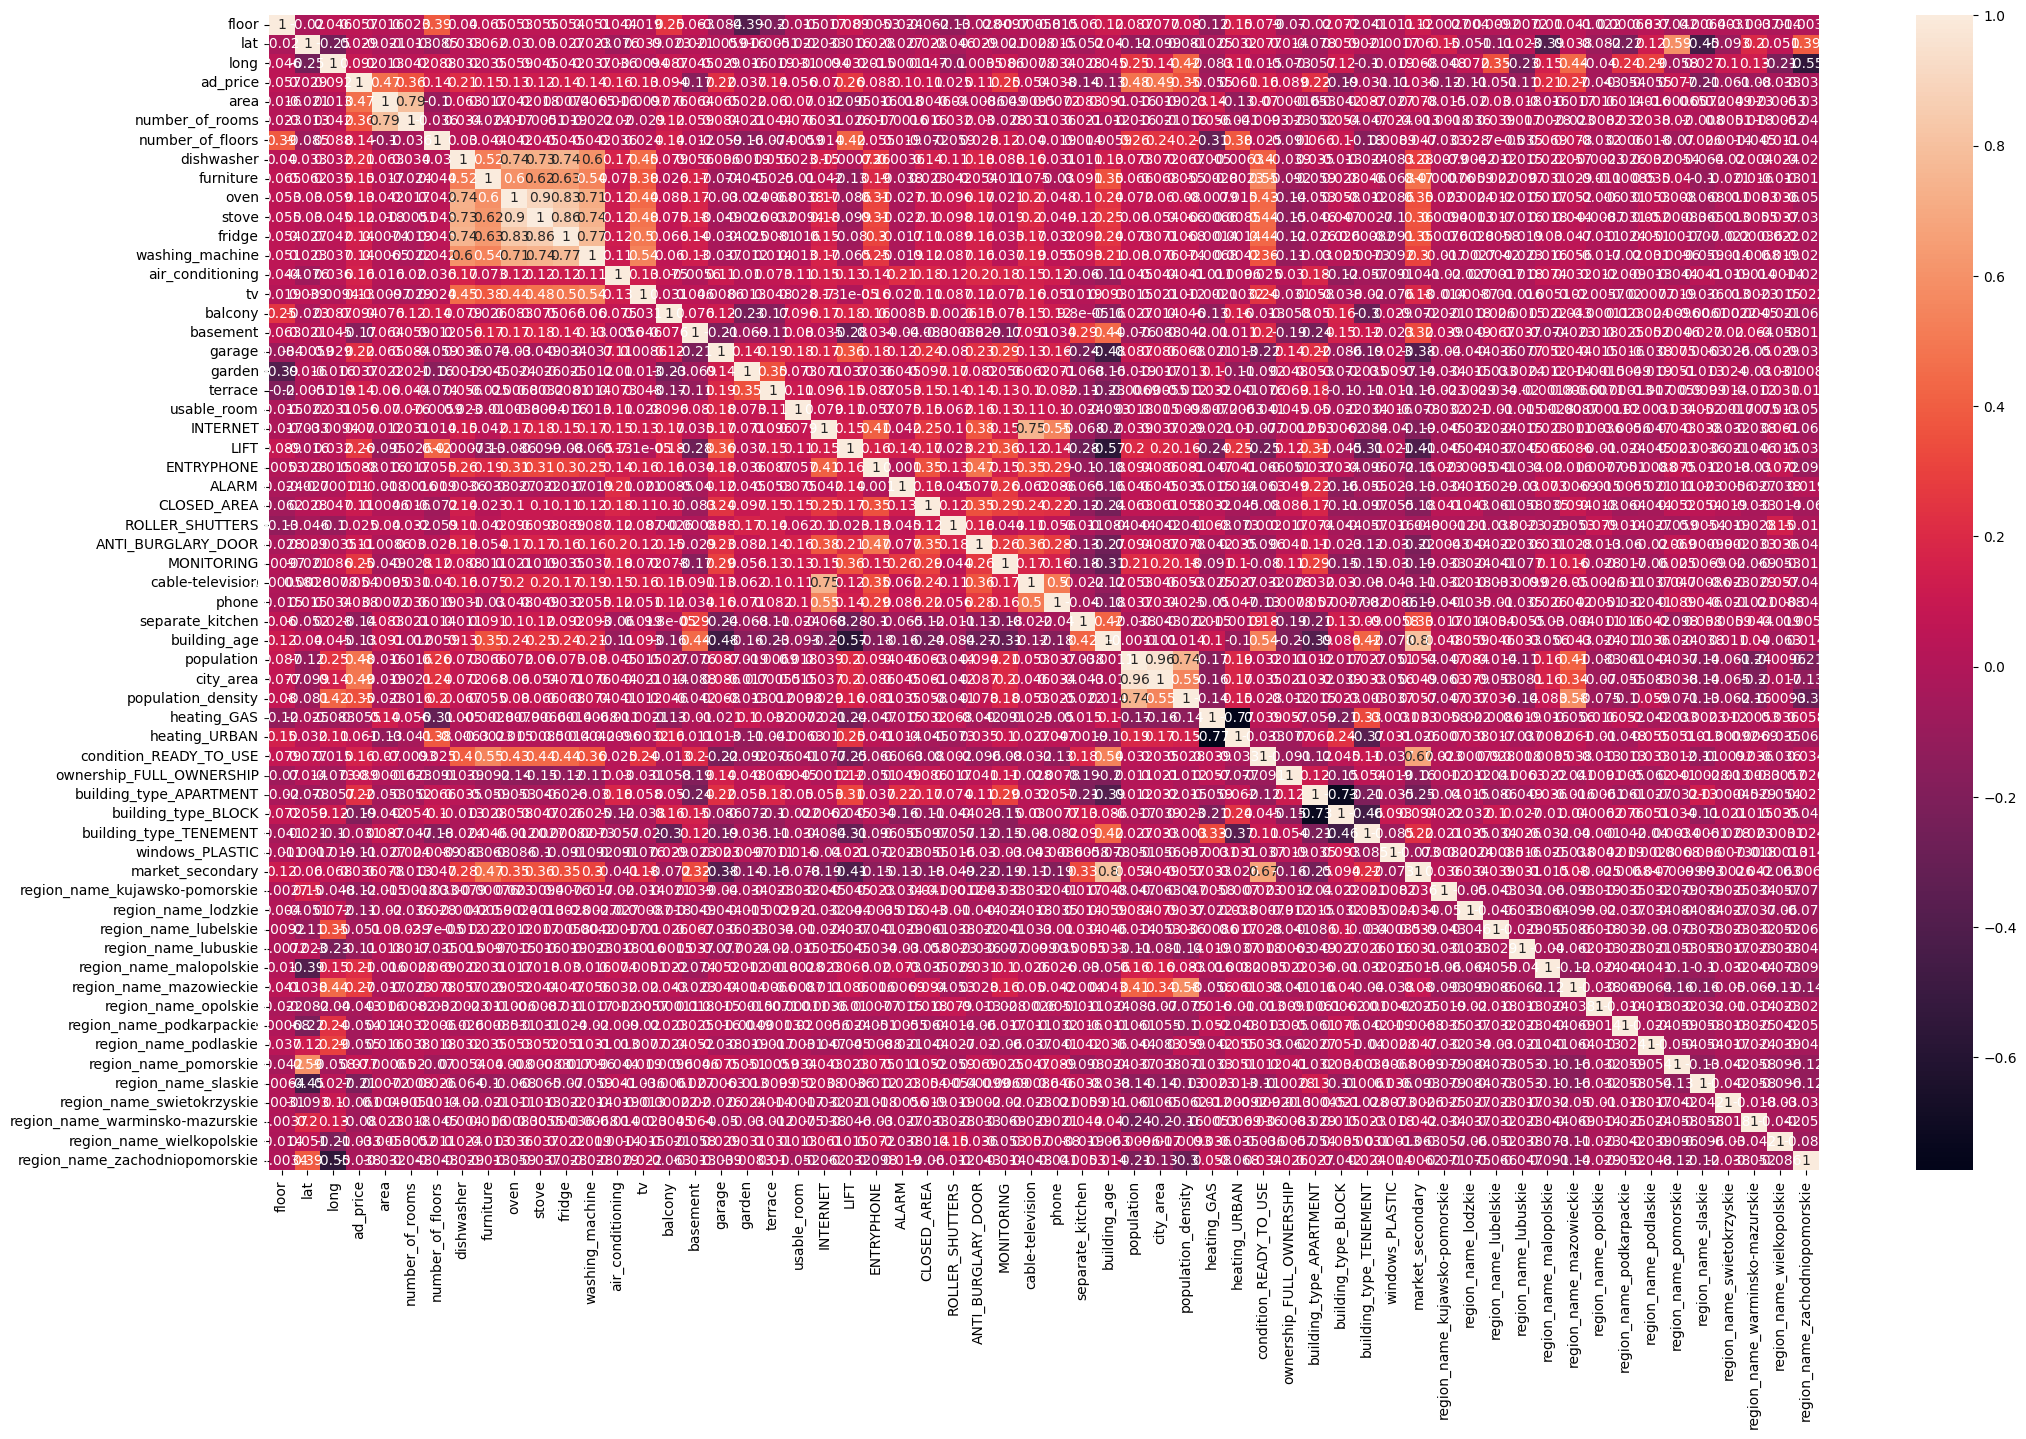

In [101]:
plt.figure(figsize=(25,15))
sns.heatmap(df.corr(), annot=True);

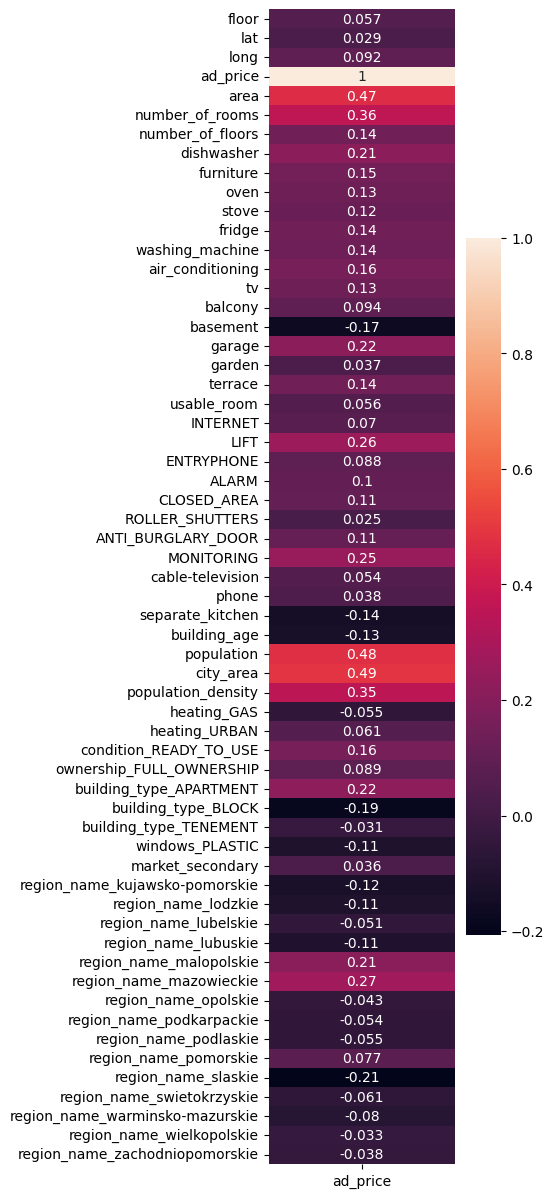

In [102]:
plt.figure(figsize=(3,15))
sns.heatmap(pd.DataFrame(df.corr()['ad_price']), annot=True);

In [103]:
(x := df
 .corr(numeric_only=True)
 .abs()['ad_price']
).sort_values(ascending=False)[x > 0.5].index

Index(['ad_price'], dtype='object')

In [104]:
(x := df
 .corr(numeric_only=True)
 .abs()['ad_price']
).sort_values(ascending=False)[x > 0.3].index

Index(['ad_price', 'city_area', 'population', 'area', 'number_of_rooms',
       'population_density'],
      dtype='object')

In [105]:
selected_corr = (x := df
 .corr(numeric_only=True)
 .abs()['ad_price']
).sort_values(ascending=False)[x > 0.15].index.to_list()

In [106]:
selected_corr

['ad_price',
 'city_area',
 'population',
 'area',
 'number_of_rooms',
 'population_density',
 'region_name_mazowieckie',
 'LIFT',
 'MONITORING',
 'building_type_APARTMENT',
 'garage',
 'dishwasher',
 'region_name_malopolskie',
 'region_name_slaskie',
 'building_type_BLOCK',
 'basement',
 'air_conditioning',
 'condition_READY_TO_USE']

### SequentialFeatureSelector

In [107]:
X = df.drop(columns=['ad_price'])
y = df["ad_price"]
model = LinearRegression()
n_features_to_select = 20

sfs = SequentialFeatureSelector(
    model, direction='forward', scoring='r2', n_features_to_select=n_features_to_select)
sfs.fit(X, y)
choices = sfs.get_support()
selected_forward = [
    feature for feature, is_selected in zip(X.columns, choices) if is_selected
]

In [108]:
X = df.drop(columns=['ad_price'])
y = df["ad_price"]
model = LinearRegression()
n_features_to_select = 20

sfs = SequentialFeatureSelector(
    model, direction='backward', scoring='r2', n_features_to_select=n_features_to_select)
sfs.fit(X, y)
choices = sfs.get_support()
selected_backward = [
    feature for feature, is_selected in zip(X.columns, choices) if is_selected
]

In [109]:
selected_features = list((set(selected_corr) - {'ad_price'}).union(set(selected_forward).intersection(selected_backward)))

In [110]:
selected_features

['city_area',
 'terrace',
 'dishwasher',
 'region_name_lodzkie',
 'region_name_mazowieckie',
 'building_type_APARTMENT',
 'LIFT',
 'region_name_slaskie',
 'building_age',
 'MONITORING',
 'number_of_rooms',
 'separate_kitchen',
 'building_type_BLOCK',
 'region_name_wielkopolskie',
 'population_density',
 'region_name_kujawsko-pomorskie',
 'region_name_malopolskie',
 'region_name_pomorskie',
 'population',
 'windows_PLASTIC',
 'garage',
 'air_conditioning',
 'condition_READY_TO_USE',
 'area',
 'basement']

# Model Building & Evaluation

In [111]:
df[selected_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31486 entries, 0 to 31485
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   city_area                       31486 non-null  float64
 1   terrace                         31486 non-null  int64  
 2   dishwasher                      31486 non-null  int64  
 3   region_name_lodzkie             31486 non-null  int64  
 4   region_name_mazowieckie         31486 non-null  int64  
 5   building_type_APARTMENT         31486 non-null  int64  
 6   LIFT                            31486 non-null  int64  
 7   region_name_slaskie             31486 non-null  int64  
 8   building_age                    31486 non-null  float64
 9   MONITORING                      31486 non-null  int64  
 10  number_of_rooms                 31486 non-null  float64
 11  separate_kitchen                31486 non-null  int64  
 12  building_type_BLOCK             

In [112]:
def get_metrics(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2 = r2_score(y_test, y_pred)
    return dict(mae=mae, mape=mape, r2=r2)

In [113]:
X = df.drop(columns=['ad_price'])
y = df['ad_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [114]:
y_pred = model.predict(X_test)
get_metrics(y_test, y_pred)

{'mae': 97594.6717619748, 'mape': 19.248725691030597, 'r2': 0.7206358275590148}

In [115]:
y_pred_train = model.predict(X_train)
get_metrics(y_train, y_pred_train)

{'mae': 99328.76180158723, 'mape': 19.82346219270627, 'r2': 0.7140038051177608}

In [116]:
X = df[selected_features]
y = df["ad_price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [117]:
y_pred = model.predict(X_test)
get_metrics(y_test, y_pred)

{'mae': 100810.44829730643,
 'mape': 19.83905347041167,
 'r2': 0.7004893930876781}

In [118]:
y_pred_train = model.predict(X_train)
get_metrics(y_train, y_pred_train)

{'mae': 102744.06729060446,
 'mape': 20.34334946633062,
 'r2': 0.6941000232599771}

In [119]:
start_time = time.time()

In [120]:
model = XGBRegressor(random_state=42)

X = df.drop(columns=['ad_price'])
y = df['ad_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

distributions = {
    'learning_rate': uniform(0.01, 0.4),
    'max_depth': randint(3, 8),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 2),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'alpha': uniform(0, 1),
    'lambda': uniform(0, 2)
}

optimizer = RandomizedSearchCV(
    model, 
    distributions, 
    n_iter=100,
    n_jobs=-1
)
optimizer.fit(X_train, y_train)

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f760de6e450>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f760e40ef50>,
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f760e420750>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f760e439cd0>})

In [121]:
elapsed_time_sec = time.time() - start_time
print(f'{round(elapsed_time_sec, 2)} sec')

162.91 sec


In [122]:
best_estimator = optimizer.best_estimator_
best_optimizer = best_estimator.get_params()['objective']
best_optimizer_params = best_estimator.get_params()

In [123]:
for k, v in best_optimizer_params.items():
    if v:
        print(f'{k}: {v}')

objective: reg:squarederror
colsample_bytree: 0.8456542289307054
gamma: 0.7511456586728127
learning_rate: 0.22337290379798314
max_depth: 7
min_child_weight: 3
missing: nan
n_estimators: 100
random_state: 42
subsample: 0.890166036044904
alpha: 0.5145127473361445
lambda: 0.5425273643475848


In [124]:
y_pred = optimizer.predict(X_test)
get_metrics(y_test, y_pred)

{'mae': 55608.92398876628,
 'mape': 10.109148166130703,
 'r2': 0.8873413094411755}

In [125]:
y_pred_train = optimizer.predict(X_train)
get_metrics(y_train, y_pred_train)

{'mae': 38897.15555894672, 'mape': 7.3645553862124125, 'r2': 0.953615426084297}

In [126]:
start_time = time.time()

In [127]:
model = XGBRegressor(random_state=42)

X = df[selected_features]
y = df['ad_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

distributions = {
    'learning_rate': uniform(0.01, 0.4),
    'max_depth': randint(3, 8),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 2),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'alpha': uniform(0, 1),
    'lambda': uniform(0, 2)
}

optimizer = RandomizedSearchCV(
    model, 
    distributions, 
    n_iter=100,
    n_jobs=-1
)
optimizer.fit(X_train, y_train)

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f760e343910>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f760e359ad0>,
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f760e396750>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f760e394410>})

In [128]:
elapsed_time_sec = time.time() - start_time
print(f'{round(elapsed_time_sec, 2)} sec')

72.97 sec


In [129]:
best_estimator = optimizer.best_estimator_
best_optimizer = best_estimator.get_params()['objective']
best_optimizer_params = best_estimator.get_params()

In [130]:
for k, v in best_optimizer_params.items():
    if v:
        print(f'{k}: {v}')

objective: reg:squarederror
colsample_bytree: 0.8431863841160665
gamma: 1.2722238824853351
learning_rate: 0.17985263863573084
max_depth: 7
min_child_weight: 8
missing: nan
n_estimators: 100
random_state: 42
subsample: 0.7167033659850668
alpha: 0.7931878349579
lambda: 1.8410492817380648


In [131]:
y_pred = optimizer.predict(X_test)
get_metrics(y_test, y_pred)

{'mae': 68633.21805161361,
 'mape': 12.244941132506623,
 'r2': 0.8323080669230662}

In [132]:
y_pred_train = optimizer.predict(X_train)
get_metrics(y_train, y_pred_train)

{'mae': 56529.39749397034, 'mape': 10.187769088835632, 'r2': 0.89541963226613}